In [541]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import newaxis
import random as rand
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns

In [292]:
## Method for moving averages

# if you want to change the number of values you want then change this line: closing_prices = df.iloc[0:30].values
# say you want more data points: closing_prices = df.iloc[0:50].values
# if you want a larger interval to average ie price(t) + price(delta + t) / interval --> then change the interval
# interval is just the days you are dividing by the changes in price

# parameters you might want to put in
def movingaverage(number_of_days, stock_list):
    
    moving_avg = []
    interval = number_of_days
    
    for stock in stock_list:
        print(stock)
        df = pd.read_csv("../Stock_CSV/" +stock + ".csv")
        df= df['4. close']
        closing_prices = df.values
        len_prices = len(closing_prices)
        print(len_prices)
        for i in range(len_prices-1):  
            if i==(len_prices-interval-1):
                break
            
            sum_prices = 0 
            for j in range(interval): 
                #print(closing_prices[i+j])
                sum_prices += closing_prices[i+j]

                
            moving_avg.append(sum_prices/interval) 
            
            #you dont need this, it is just a visual
            #print('sum:',sum_prices)
            #print('\n') 
            #print('moving avg:',moving_avg)
            #print('\n')
        
        moving_avg.reverse()
        return moving_avg
            
        #clearing moving averages list - you might not need this
nums = movingaverage(10, ["AAPL"])
len(nums)

AAPL
5032


5021

In [1117]:
def convertData(leng, stock):
    leng = leng-1
    df = pd.DataFrame()
    raw_seq = pd.read_csv("../Stock_CSV/" +stock + ".csv")
    raw_seq = raw_seq.set_index('date')
    raw_seq = raw_seq.iloc[::-1]
    seq = np.array(raw_seq['4. close'])
    date = round(len(seq)*.6)
    seq = seq[date:]
    #scaler = preprocessing.StandardScaler()
    #seq = scaler.fit_transform(seq.reshape(-1,1))
    rolling_mean = raw_seq['4. close'][date:].rolling(window=leng).mean()
    #rolling_mean = np.array(rolling_mean)
    #rolling_mean = scaler.fit_transform(rolling_mean.reshape(-1,1))
    #seq = seq.reshape(seq.shape[0])
    #rolling_mean = rolling_mean.reshape(rolling_mean.shape[0])
    df['pred'] = seq[leng:]
    for i in range(0,leng+1):
        df['val'+str(i)] = seq[i:len(seq)-leng+i]
    df['move_avg'] = rolling_mean.values[leng:]
    return df

In [1118]:
df = convertData(10,'AAPL')
y = df['pred'].values
x = df.drop('pred', axis= 1)
x = x.values
scalerX = preprocessing.StandardScaler()
scalerY = preprocessing.StandardScaler()
x = scalerX.fit_transform(x)
y = scalerY.fit_transform(y.reshape(-1,1))
x.shape

(2004, 11)

In [1119]:
df = pd.read_csv("../Stock_CSV/" +'AAPL' + ".csv")
rolling_mean = df['4. close'].rolling(window=10).mean()

In [1120]:
rolling_mean

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
5027    122.353
5028    121.328
5029    119.578
5030    119.391
5031    119.060
Name: 4. close, Length: 5032, dtype: float64

In [1121]:
df.shape

(5032, 6)

In [1122]:
def normalise_windows(window_data):
    normalised_data = []
    normalised_window_0 = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
        normalised_window_0.append(window[0])
    return (normalised_data,normalised_window_0)
#divides each value 

In [1123]:
def reverse_normalise(y, reverse, start_val):
    normalised_data = []
    i = start_val
    for valuey in y:
        value = ((float(valuey)+1) * float(reverse[i])) 
        normalised_data.append(value)
        i = i+1
    return normalised_data

In [1124]:
def set_data(stock, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ stock +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length ):
            result.append(seq[index: index + sequence_length])
        
        result, result_reverse = normalise_windows(result)
        
        result = np.array(result)
        print(result.shape)
        #result_reverse = []
        row = round(0.95 * len(result))
        train = result[:int(row), :]
        #np.random.shuffle(train)
        x_train = train[:, :-1]
        y_train = train[:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        result.shape
        return (x_train, x_test, y_train, y_test, result_reverse, row)
    #except:
        #print("file" + stock + ".csv not found")


In [1125]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('AAPL',seq_length)
y_test

(5021, 11)


array([ 0.05420729,  0.04695973,  0.04177996,  0.02695598,  0.03982595,
        0.04174971,  0.03822335,  0.03688156,  0.03839599,  0.02322799,
        0.02689118,  0.02886308,  0.00722783,  0.05656211,  0.02963619,
        0.03870303,  0.01931257, -0.02226721, -0.02056382, -0.02221356,
       -0.03485071, -0.09232198, -0.0598495 , -0.09310279, -0.09117858,
       -0.10743802, -0.12178626, -0.0801538 , -0.09916215, -0.10492228,
       -0.09235217, -0.04032953, -0.0597901 , -0.06610098, -0.07896675,
       -0.08306878, -0.01884319, -0.02175777,  0.01334938,  0.05838807,
        0.07604626,  0.09302587,  0.09476829,  0.08889512,  0.10093106,
        0.11881131,  0.10470942,  0.08398159,  0.07688155,  0.04538522,
        0.03115588,  0.00390124,  0.02888923,  0.02879217,  0.02687558,
        0.03950694,  0.02156715,  0.033052  ,  0.02391457,  0.00623805,
        0.01339511,  0.03916756,  0.00975976,  0.01782317,  0.03683306,
        0.01463657,  0.00305825,  0.00611516, -0.00803016,  0.03

In [1126]:
def set_stock_list():
    arr = []
    with open("../NASDAQ.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(',')
            arr.append(currentline)
    newarr = np.array(arr[0])
    return newarr

In [1127]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [1128]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted


In [1129]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [1130]:
def plot_results_multiple(predicted_data, true_data, prediction_len, stock):
    fig = plt.figure(facecolor='white',figsize = (10,5))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)
        plt.title(stock + " Closing Stock Price")
        plt.legend()
    plt.show()

In [1131]:
from keras.models import load_model
#model.save('stock_NN.h5')

In [1132]:
def accuracy(y_true, y_pred):
    prev_true = y_true[0]
    prev_pred = y_pred[0]
    correct = 0
    incorrect = 0
    for i in range(1,len(y_pred)):
        if prev_true < y_true[i] and prev_true < y_pred[i]:
            correct = correct+1
        elif prev_true > y_true[i] and prev_true > y_pred[i]:
            correct = correct+1
        else:
            incorrect = incorrect+1
        prev_true = y_true[i]
        prev_pred = y_pred[i]        
    return (correct, incorrect)

In [1133]:
def n_day_accuracy(days, y_true, pred):
    y_pred = []
    for nums in pred:
        y_pred.append(nums[-1])
    prev_true = y_true[0]
    correct = 0
    incorrect = 0
    j = days-1
    for i in range(0, len(y_pred)-1):
        if (prev_true < y_true[j] and prev_true < y_pred[i]) or (prev_true > y_true[j] and prev_true > y_pred[i]):
            correct = correct+1
        else:
            incorrect = incorrect+1
        
        if j > len(y_true)-1:
            break
        prev_true = y_true[j]
        j = j + days
        if j > len(y_true)-1:
            break
    return (correct, incorrect)
    

In [1134]:
def build_model(shape):
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(shape,1)))
    regressor.add(Dropout(0.6))
    # Second LSTM layer
    #regressor.add(LSTM(units=50, return_sequences=True))
    #regressor.add(Dropout(0.6))
    # Third LSTM layer
    #regressor.add(LSTM(units=50, return_sequences=True))
    #regressor.add(Dropout(0.7))
    #model.add(Activation('sigmoid'))
    # Fourth LSTM layer 
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.7))
    # The output layer
   
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
    return regressor

In [1135]:
def scale(x_train, x_test, y_train,y_test, scalerX, scalerY):
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
    x_train = scalerX.fit_transform(x_train)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
    x_test = scalerX.fit_transform(x_test)
    y_train = y_train.reshape(-1,1)
    y_train = scalerX.fit_transform(y_train)
    y_test = y_test.reshape(-1,1)
    y_test = scalerX.fit_transform(y_test)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])
    

def prepare_data(stock, length, scalerX, scalerY):
    df = convertData(length,stock)
    y = df['pred'].values
    x = df.drop('pred', axis= 1)
    x = x.values
    x = scalerX.fit_transform(x)
    y = scalerY.fit_transform(y.reshape(-1,1))
    num = round(len(x)*.80)
    x = x.reshape(x.shape[0],x.shape[1],1)
    x_train = x[:num]
    x_test = x[num:]
    y_train = y[:num]
    y_test = y[num:]
    
    return (x_train, x_test, y_train,y_test, scalerX, scalerY)

In [1136]:
seq_length = 10


In [1137]:
model = build_model(seq_length+1)

In [ ]:
epochs = 3
stock_list = set_stock_list()
#for i in range(0,150):
for stock in stock_list:
    #j = rand.randrange(0, len(stock_list)-1)
    #print(stock_list[j])
    print(stock)
    try:
        x_train,x_test,y_train,y_test, scalerX, scalerY = prepare_data(stock , seq_length, scalerX, scalerY)
        #x_train,x_test,y_train,y_test, reverse, row = set_data(stock , seq_length)
        hist = model.fit(
                x_train,
                y_train,
                batch_size = 256,
                nb_epoch=epochs,
                validation_data=(x_test, y_test))
    except:
        print("not found")


AACG
Train on 976 samples, validate on 244 samples
Epoch 1/3
976/976 [==============================] - 1s 558us/step - loss: 0.6342 - val_loss: 0.6179
Epoch 2/3
976/976 [==============================] - 0s 56us/step - loss: 0.2236 - val_loss: 0.1021
Epoch 3/3
976/976 [==============================] - 0s 61us/step - loss: 0.1489 - val_loss: 0.0149
AAL
Train on 1164 samples, validate on 291 samples
Epoch 1/3
1164/1164 [==============================] - 0s 61us/step - loss: 0.1067 - val_loss: 0.2107
Epoch 2/3
1164/1164 [==============================] - 0s 61us/step - loss: 0.0971 - val_loss: 0.2387
Epoch 3/3
1164/1164 [==============================] - 0s 62us/step - loss: 0.0920 - val_loss: 0.2279
AAME
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0822 - val_loss: 0.2034
Epoch 2/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0766 - val_loss: 0.1555
Epoch 3/3
1603/1603 [==============

ACIU
Train on 278 samples, validate on 70 samples
Epoch 1/3
278/278 [==============================] - 0s 111us/step - loss: 0.1139 - val_loss: 0.0529
Epoch 2/3
278/278 [==============================] - 0s 104us/step - loss: 0.1198 - val_loss: 0.0633
Epoch 3/3
278/278 [==============================] - 0s 111us/step - loss: 0.1272 - val_loss: 0.0591
ACIW
not found
ACLS
Train on 1583 samples, validate on 396 samples
Epoch 1/3
1583/1583 [==============================] - 0s 60us/step - loss: 0.0555 - val_loss: 0.0095
Epoch 2/3
1583/1583 [==============================] - 0s 60us/step - loss: 0.0563 - val_loss: 0.0235
Epoch 3/3
1583/1583 [==============================] - 0s 61us/step - loss: 0.0568 - val_loss: 0.0068
ACMR
Train on 188 samples, validate on 47 samples
Epoch 1/3
188/188 [==============================] - 0s 90us/step - loss: 0.0695 - val_loss: 0.1008
Epoch 2/3
188/188 [==============================] - 0s 80us/step - loss: 0.0498 - val_loss: 0.0980
Epoch 3/3
188/188 [=====

395/395 [==============================] - 0s 78us/step - loss: 0.0712 - val_loss: 0.0068
Epoch 2/3
395/395 [==============================] - 0s 78us/step - loss: 0.0648 - val_loss: 0.0066
Epoch 3/3
395/395 [==============================] - 0s 78us/step - loss: 0.0585 - val_loss: 0.0059
ADSK
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0353 - val_loss: 0.0268
Epoch 2/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0330 - val_loss: 0.0340
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0357 - val_loss: 0.0098
ADTN
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0488 - val_loss: 0.0124
Epoch 2/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0402 - val_loss: 0.0357
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0460 - val_loss: 0

534/534 [==============================] - 0s 75us/step - loss: 0.0509 - val_loss: 0.0217
Epoch 2/3
534/534 [==============================] - 0s 84us/step - loss: 0.0528 - val_loss: 0.0088
Epoch 3/3
534/534 [==============================] - 0s 86us/step - loss: 0.0538 - val_loss: 0.0064
AGLE
Train on 316 samples, validate on 79 samples
Epoch 1/3
316/316 [==============================] - 0s 101us/step - loss: 0.0606 - val_loss: 0.1072
Epoch 2/3
316/316 [==============================] - 0s 98us/step - loss: 0.0592 - val_loss: 0.0976
Epoch 3/3
316/316 [==============================] - 0s 92us/step - loss: 0.0538 - val_loss: 0.1068
AGMH
Train on 153 samples, validate on 38 samples
Epoch 1/3
153/153 [==============================] - 0s 111us/step - loss: 0.1460 - val_loss: 0.0245
Epoch 2/3
153/153 [==============================] - 0s 98us/step - loss: 0.1246 - val_loss: 0.0235
Epoch 3/3
153/153 [==============================] - 0s 111us/step - loss: 0.1076 - val_loss: 0.0270
AGNC
Tr

Epoch 2/3
40/40 [==============================] - 0s 399us/step - loss: 0.2982 - val_loss: 0.4653
Epoch 3/3
40/40 [==============================] - 0s 449us/step - loss: 0.2255 - val_loss: 0.4682
AKAM
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0446 - val_loss: 0.0166
Epoch 2/3
1603/1603 [==============================] - 0s 64us/step - loss: 0.0425 - val_loss: 0.0188
Epoch 3/3
1603/1603 [==============================] - 0s 64us/step - loss: 0.0412 - val_loss: 0.0121
AKBA
not found
AKCA
Train on 214 samples, validate on 53 samples
Epoch 1/3
214/214 [==============================] - 0s 79us/step - loss: 0.0561 - val_loss: 0.0161
Epoch 2/3
214/214 [==============================] - 0s 79us/step - loss: 0.0588 - val_loss: 0.0155
Epoch 3/3
214/214 [==============================] - 0s 84us/step - loss: 0.0549 - val_loss: 0.0242
AKER
Train on 494 samples, validate on 123 samples
Epoch 1/3
494/494 [=========

1071/1071 [==============================] - 0s 64us/step - loss: 0.0398 - val_loss: 0.0158
Epoch 3/3
1071/1071 [==============================] - 0s 66us/step - loss: 0.0388 - val_loss: 0.0138
ALNA
Train on 189 samples, validate on 47 samples
Epoch 1/3
189/189 [==============================] - 0s 79us/step - loss: 0.0740 - val_loss: 0.0306
Epoch 2/3
189/189 [==============================] - 0s 84us/step - loss: 0.0666 - val_loss: 0.0071
Epoch 3/3
189/189 [==============================] - 0s 84us/step - loss: 0.0548 - val_loss: 0.0218
ALNY
Train on 1270 samples, validate on 318 samples
Epoch 1/3
1270/1270 [==============================] - 0s 53us/step - loss: 0.0616 - val_loss: 0.0154
Epoch 2/3
1270/1270 [==============================] - 0s 55us/step - loss: 0.0739 - val_loss: 0.0045
Epoch 3/3
1270/1270 [==============================] - 0s 57us/step - loss: 0.0608 - val_loss: 0.0038
ALOT
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [=========================

Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0443 - val_loss: 0.0342
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0512 - val_loss: 0.0033
AMHC
not found
AMHCU
Train on 23 samples, validate on 6 samples
Epoch 1/3
23/23 [==============================] - 0s 737us/step - loss: 0.0778 - val_loss: 0.1074
Epoch 2/3
23/23 [==============================] - 0s 694us/step - loss: 0.1247 - val_loss: 0.0389
Epoch 3/3
23/23 [==============================] - 0s 650us/step - loss: 0.0946 - val_loss: 0.0683
AMHCW
not found
AMKR
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0495 - val_loss: 0.0059
Epoch 2/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0537 - val_loss: 0.0069
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0504 - val_loss: 0.0080
AMNB
Train on 1603 samples, validate on 401 samples
Epoch 1/3

Epoch 2/3
197/197 [==============================] - 0s 86us/step - loss: 0.0722 - val_loss: 0.0039
Epoch 3/3
197/197 [==============================] - 0s 81us/step - loss: 0.0682 - val_loss: 0.0011
ANDE
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0657 - val_loss: 0.0011
Epoch 2/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0709 - val_loss: 0.0044
Epoch 3/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0671 - val_loss: 0.0012
ANGI
not found
ANGL
Train on 637 samples, validate on 159 samples
Epoch 1/3
637/637 [==============================] - 0s 69us/step - loss: 0.0290 - val_loss: 0.3029
Epoch 2/3
637/637 [==============================] - 0s 75us/step - loss: 0.0321 - val_loss: 0.2842
Epoch 3/3
637/637 [==============================] - 0s 69us/step - loss: 0.0280 - val_loss: 0.2991
ANGO
Train on 1270 samples, validate on 318 samples
Epoch 1/3
1270/1270 [===

433/433 [==============================] - 0s 67us/step - loss: 0.0256 - val_loss: 0.2251
Epoch 2/3
433/433 [==============================] - 0s 74us/step - loss: 0.0186 - val_loss: 0.1742
Epoch 3/3
433/433 [==============================] - 0s 69us/step - loss: 0.0172 - val_loss: 0.1394
APTX
Train on 138 samples, validate on 35 samples
Epoch 1/3
138/138 [==============================] - 0s 116us/step - loss: 0.0929 - val_loss: 0.0324
Epoch 2/3
138/138 [==============================] - 0s 123us/step - loss: 0.0638 - val_loss: 0.0361
Epoch 3/3
138/138 [==============================] - 0s 123us/step - loss: 0.0642 - val_loss: 0.0321
APVO
Train on 293 samples, validate on 73 samples
Epoch 1/3
293/293 [==============================] - 0s 109us/step - loss: 0.0498 - val_loss: 0.0905
Epoch 2/3
293/293 [==============================] - 0s 102us/step - loss: 0.0448 - val_loss: 0.0944
Epoch 3/3
293/293 [==============================] - 0s 112us/step - loss: 0.0521 - val_loss: 0.0878
APWC

Epoch 2/3
98/98 [==============================] - 0s 173us/step - loss: 0.0452 - val_loss: 0.0318
Epoch 3/3
98/98 [==============================] - 0s 163us/step - loss: 0.0683 - val_loss: 0.0255
ARTLW
not found
ARTNA
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0494 - val_loss: 0.0067
Epoch 2/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0523 - val_loss: 0.0090
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0503 - val_loss: 0.0024
ARTW
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0550 - val_loss: 0.0017
Epoch 2/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0578 - val_loss: 5.9985e-04
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0570 - val_loss: 8.9017e-04
ARVN
Train on 116 samples, validate on 29 samples
Epoch 1/3
1

1109/1109 [==============================] - 0s 62us/step - loss: 0.0399 - val_loss: 0.0054
Epoch 2/3
1109/1109 [==============================] - 0s 63us/step - loss: 0.0442 - val_loss: 0.0040
Epoch 3/3
1109/1109 [==============================] - 0s 63us/step - loss: 0.0379 - val_loss: 0.0026
ATEX
Train on 410 samples, validate on 103 samples
Epoch 1/3
410/410 [==============================] - 0s 73us/step - loss: 0.0572 - val_loss: 0.0154
Epoch 2/3
410/410 [==============================] - 0s 71us/step - loss: 0.0772 - val_loss: 0.0139
Epoch 3/3
410/410 [==============================] - 0s 72us/step - loss: 0.0602 - val_loss: 0.0146
ATHE
Train on 1544 samples, validate on 386 samples
Epoch 1/3
1544/1544 [==============================] - 0s 64us/step - loss: 0.0657 - val_loss: 0.0114
Epoch 2/3
1544/1544 [==============================] - 0s 60us/step - loss: 0.0731 - val_loss: 0.0041
Epoch 3/3
1544/1544 [==============================] - 0s 61us/step - loss: 0.0571 - val_loss: 0.

805/805 [==============================] - 0s 67us/step - loss: 0.0515 - val_loss: 0.0299
Epoch 2/3
805/805 [==============================] - 0s 71us/step - loss: 0.0514 - val_loss: 0.0328
Epoch 3/3
805/805 [==============================] - 0s 71us/step - loss: 0.0516 - val_loss: 0.0293
AVGO
Train on 853 samples, validate on 213 samples
Epoch 1/3
853/853 [==============================] - 0s 65us/step - loss: 0.0397 - val_loss: 0.0066
Epoch 2/3
853/853 [==============================] - 0s 67us/step - loss: 0.0500 - val_loss: 0.0058
Epoch 3/3
853/853 [==============================] - 0s 65us/step - loss: 0.0451 - val_loss: 0.0045
AVGOP
Train on 37 samples, validate on 9 samples
Epoch 1/3
37/37 [==============================] - 0s 431us/step - loss: 0.0672 - val_loss: 0.0090
Epoch 2/3
37/37 [==============================] - 0s 431us/step - loss: 0.0696 - val_loss: 0.0083
Epoch 3/3
37/37 [==============================] - 0s 445us/step - loss: 0.0551 - val_loss: 0.0076
AVGR
Train on

1603/1603 [==============================] - 0s 61us/step - loss: 0.0234 - val_loss: 0.0083
Epoch 2/3
1603/1603 [==============================] - 0s 63us/step - loss: 0.0228 - val_loss: 0.0078
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0228 - val_loss: 0.0108
BATRA
Train on 314 samples, validate on 78 samples
Epoch 1/3
314/314 [==============================] - 0s 92us/step - loss: 0.0203 - val_loss: 0.1490
Epoch 2/3
314/314 [==============================] - 0s 95us/step - loss: 0.0155 - val_loss: 0.1128
Epoch 3/3
314/314 [==============================] - 0s 95us/step - loss: 0.0248 - val_loss: 0.1243
BATRK
not found
BBBY
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0481 - val_loss: 0.0132
Epoch 2/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0444 - val_loss: 6.0083e-04
Epoch 3/3
1603/1603 [==============================] - 0s 61us/step - loss: 0

1138/1138 [==============================] - 0s 66us/step - loss: 0.0330 - val_loss: 0.0393
Epoch 2/3
1138/1138 [==============================] - 0s 68us/step - loss: 0.0341 - val_loss: 0.0434
Epoch 3/3
1138/1138 [==============================] - 0s 67us/step - loss: 0.0312 - val_loss: 0.0482
BEAT
Train on 965 samples, validate on 241 samples
Epoch 1/3
965/965 [==============================] - 0s 60us/step - loss: 0.0554 - val_loss: 0.0059
Epoch 2/3
965/965 [==============================] - 0s 58us/step - loss: 0.0552 - val_loss: 0.0191
Epoch 3/3
965/965 [==============================] - 0s 57us/step - loss: 0.0616 - val_loss: 0.0043
BECN
Train on 1246 samples, validate on 311 samples
Epoch 1/3
1246/1246 [==============================] - 0s 54us/step - loss: 0.0583 - val_loss: 0.0129
Epoch 2/3
1246/1246 [==============================] - 0s 55us/step - loss: 0.0599 - val_loss: 0.0060
Epoch 3/3
1246/1246 [==============================] - 0s 55us/step - loss: 0.0528 - val_loss: 0.

1603/1603 [==============================] - 0s 61us/step - loss: 0.0572 - val_loss: 0.0016
Epoch 2/3
1603/1603 [==============================] - 0s 67us/step - loss: 0.0586 - val_loss: 0.0037
Epoch 3/3
1603/1603 [==============================] - 0s 64us/step - loss: 0.0527 - val_loss: 0.0032
BIS
not found
BJK
Train on 977 samples, validate on 244 samples
Epoch 1/3
977/977 [==============================] - 0s 57us/step - loss: 0.0543 - val_loss: 0.0238
Epoch 2/3
977/977 [==============================] - 0s 56us/step - loss: 0.0668 - val_loss: 0.0233
Epoch 3/3
977/977 [==============================] - 0s 55us/step - loss: 0.0552 - val_loss: 0.0168
BJRI
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 64us/step - loss: 0.0399 - val_loss: 0.0256
Epoch 2/3
1603/1603 [==============================] - 0s 66us/step - loss: 0.0384 - val_loss: 0.0237
Epoch 3/3
1603/1603 [==============================] - 0s 65us/step - loss: 0.0398 -

Epoch 2/3
255/255 [==============================] - 0s 59us/step - loss: 0.0120 - val_loss: 0.1913
Epoch 3/3
255/255 [==============================] - 0s 59us/step - loss: 0.0138 - val_loss: 0.1913
BMRA
Train on 1223 samples, validate on 306 samples
Epoch 1/3
1223/1223 [==============================] - 0s 58us/step - loss: 0.0503 - val_loss: 0.1900
Epoch 2/3
1223/1223 [==============================] - 0s 55us/step - loss: 0.0515 - val_loss: 0.1611
Epoch 3/3
1223/1223 [==============================] - 0s 56us/step - loss: 0.0448 - val_loss: 0.1625
BMRC
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0470 - val_loss: 0.0268
Epoch 2/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0502 - val_loss: 0.0189
Epoch 3/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0488 - val_loss: 0.0260
BMRN
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [===========

Epoch 2/3
910/910 [==============================] - 0s 60us/step - loss: 0.0414 - val_loss: 0.0186
Epoch 3/3
910/910 [==============================] - 0s 61us/step - loss: 0.0432 - val_loss: 0.0276
BPOPN
not found
BPRN
Train on 295 samples, validate on 74 samples
Epoch 1/3
295/295 [==============================] - 0s 101us/step - loss: 0.0287 - val_loss: 0.1901
Epoch 2/3
295/295 [==============================] - ETA: 0s - loss: 0.043 - 0s 101us/step - loss: 0.0400 - val_loss: 0.1290
Epoch 3/3
295/295 [==============================] - 0s 101us/step - loss: 0.0298 - val_loss: 0.1401
BPTH
Train on 968 samples, validate on 242 samples
Epoch 1/3
968/968 [==============================] - 0s 55us/step - loss: 0.0499 - val_loss: 0.0105
Epoch 2/3
968/968 [==============================] - 0s 55us/step - loss: 0.0465 - val_loss: 0.0199
Epoch 3/3
968/968 [==============================] - ETA: 0s - loss: 0.079 - 0s 56us/step - loss: 0.0591 - val_loss: 0.0169
BPY
Train on 561 samples, valida

Epoch 2/3
639/639 [==============================] - 0s 66us/step - loss: 0.0606 - val_loss: 0.1755
Epoch 3/3
639/639 [==============================] - 0s 67us/step - loss: 0.0554 - val_loss: 0.1792
BSCL
Train on 535 samples, validate on 134 samples
Epoch 1/3
535/535 [==============================] - 0s 76us/step - loss: 0.0386 - val_loss: 0.2227
Epoch 2/3
535/535 [==============================] - 0s 74us/step - loss: 0.0441 - val_loss: 0.2297
Epoch 3/3
535/535 [==============================] - 0s 78us/step - loss: 0.0403 - val_loss: 0.2272
BSCM
Train on 535 samples, validate on 134 samples
Epoch 1/3
535/535 [==============================] - 0s 76us/step - loss: 0.0473 - val_loss: 0.1262
Epoch 2/3
535/535 [==============================] - 0s 76us/step - loss: 0.0428 - val_loss: 0.1163
Epoch 3/3
535/535 [==============================] - 0s 76us/step - loss: 0.0401 - val_loss: 0.1055
BSCN
not found
BSCO
Train on 441 samples, validate on 110 samples
Epoch 1/3
441/441 [=============

Epoch 3/3
28/28 [==============================] - 0s 570us/step - loss: 0.1046 - val_loss: 0.0545
BSMT
Train on 36 samples, validate on 9 samples
Epoch 1/3
36/36 [==============================] - 0s 416us/step - loss: 0.0871 - val_loss: 0.0733
Epoch 2/3
36/36 [==============================] - 0s 430us/step - loss: 0.0866 - val_loss: 0.0556
Epoch 3/3
36/36 [==============================] - 0s 471us/step - loss: 0.1288 - val_loss: 0.0663
BSQR
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0520 - val_loss: 0.0136
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0467 - val_loss: 0.0109
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0443 - val_loss: 0.0086
BSRR
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0488 - val_loss: 0.0030
Epoch 2/3
1603/1603 [=======================

Epoch 3/3
230/230 [==============================] - 0s 65us/step - loss: 0.0210 - val_loss: 0.0699
CAKE
not found
CALA
Train on 438 samples, validate on 109 samples
Epoch 1/3
438/438 [==============================] - 0s 64us/step - loss: 0.0514 - val_loss: 0.0107
Epoch 2/3
438/438 [==============================] - 0s 68us/step - loss: 0.0508 - val_loss: 0.0139
Epoch 3/3
438/438 [==============================] - 0s 64us/step - loss: 0.0501 - val_loss: 0.0101
CALB
Train on 188 samples, validate on 47 samples
Epoch 1/3
188/188 [==============================] - 0s 80us/step - loss: 0.0106 - val_loss: 0.0531
Epoch 2/3
188/188 [==============================] - 0s 80us/step - loss: 0.0097 - val_loss: 0.0558
Epoch 3/3
188/188 [==============================] - 0s 80us/step - loss: 0.0145 - val_loss: 0.0510
CALM
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0839 - val_loss: 0.0011
Epoch 2/3
1603/1603 [=========

1406/1406 [==============================] - 0s 56us/step - loss: 0.0470 - val_loss: 0.0032
Epoch 3/3
1406/1406 [==============================] - 0s 55us/step - loss: 0.0542 - val_loss: 0.0049
CBAY
Train on 491 samples, validate on 123 samples
Epoch 1/3
491/491 [==============================] - 0s 61us/step - loss: 0.0283 - val_loss: 0.0135
Epoch 2/3
491/491 [==============================] - 0s 56us/step - loss: 0.0321 - val_loss: 0.0122
Epoch 3/3
491/491 [==============================] - 0s 59us/step - loss: 0.0377 - val_loss: 0.0248
CBFV
Train on 1510 samples, validate on 377 samples
Epoch 1/3
1510/1510 [==============================] - 0s 52us/step - loss: 0.0616 - val_loss: 0.0042
Epoch 2/3
1510/1510 [==============================] - 0s 54us/step - loss: 0.0613 - val_loss: 0.0076
Epoch 3/3
1510/1510 [==============================] - 0s 59us/step - loss: 0.0553 - val_loss: 0.0066
CBIO
not found
CBLI
Train on 1098 samples, validate on 274 samples
Epoch 1/3
1098/1098 [=========

377/377 [==============================] - 0s 74us/step - loss: 0.0154 - val_loss: 0.1453
Epoch 3/3
377/377 [==============================] - 0s 78us/step - loss: 0.0140 - val_loss: 0.1464
CDLX
Train on 167 samples, validate on 42 samples
Epoch 1/3
167/167 [==============================] - 0s 96us/step - loss: 0.0443 - val_loss: 0.0111
Epoch 2/3
167/167 [==============================] - 0s 96us/step - loss: 0.0588 - val_loss: 0.0380
Epoch 3/3
167/167 [==============================] - 0s 102us/step - loss: 0.0610 - val_loss: 0.0134
CDMO
Train on 174 samples, validate on 44 samples
Epoch 1/3
174/174 [==============================] - 0s 92us/step - loss: 0.0548 - val_loss: 0.0297
Epoch 2/3
174/174 [==============================] - 0s 92us/step - loss: 0.0404 - val_loss: 0.0310
Epoch 3/3
174/174 [==============================] - 0s 80us/step - loss: 0.0607 - val_loss: 0.0405
CDMOP
Train on 174 samples, validate on 44 samples
Epoch 1/3
174/174 [==============================] - 0s 92

319/319 [==============================] - 0s 88us/step - loss: 0.0184 - val_loss: 0.1805
Epoch 3/3
319/319 [==============================] - 0s 100us/step - loss: 0.0156 - val_loss: 0.1689
CFA
Train on 458 samples, validate on 115 samples
Epoch 1/3
458/458 [==============================] - 0s 61us/step - loss: 0.0190 - val_loss: 0.0624
Epoch 2/3
458/458 [==============================] - 0s 65us/step - loss: 0.0241 - val_loss: 0.0868
Epoch 3/3
458/458 [==============================] - 0s 65us/step - loss: 0.0201 - val_loss: 0.0871
CFB
not found
CFBI
Train on 230 samples, validate on 58 samples
Epoch 1/3
230/230 [==============================] - 0s 74us/step - loss: 0.0140 - val_loss: 0.1108
Epoch 2/3
230/230 [==============================] - 0s 65us/step - loss: 0.0140 - val_loss: 0.1016
Epoch 3/3
230/230 [==============================] - 0s 65us/step - loss: 0.0130 - val_loss: 0.0929
CFBK
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [======================

374/374 [==============================] - 0s 80us/step - loss: 0.0665 - val_loss: 0.0031
Epoch 3/3
374/374 [==============================] - 0s 81us/step - loss: 0.0602 - val_loss: 0.0022
CHMG
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0441 - val_loss: 0.0024
Epoch 2/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0446 - val_loss: 0.0510
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0439 - val_loss: 0.0169
CHNA
Train on 145 samples, validate on 36 samples
Epoch 1/3
145/145 [==============================] - 0s 117us/step - loss: 0.0508 - val_loss: 0.0467
Epoch 2/3
145/145 [==============================] - 0s 117us/step - loss: 0.0526 - val_loss: 0.0478
Epoch 3/3
145/145 [==============================] - 0s 110us/step - loss: 0.0672 - val_loss: 0.0443
CHNG
Train on 57 samples, validate on 14 samples
Epoch 1/3
57/57 [==============================] -

Epoch 3/3
15/15 [==============================] - 0s 1ms/step - loss: 0.1698 - val_loss: 0.0138
CIICW
not found
CIL
Train on 366 samples, validate on 92 samples
Epoch 1/3
366/366 [==============================] - 0s 79us/step - loss: 0.0245 - val_loss: 0.0959
Epoch 2/3
366/366 [==============================] - 0s 82us/step - loss: 0.0259 - val_loss: 0.0923
Epoch 3/3
366/366 [==============================] - 0s 84us/step - loss: 0.0273 - val_loss: 0.0897
CINF
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0268 - val_loss: 0.0017
Epoch 2/3
1603/1603 [==============================] - 0s 63us/step - loss: 0.0280 - val_loss: 0.0017
Epoch 3/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0280 - val_loss: 0.0025
CIVB
Train on 1541 samples, validate on 385 samples
Epoch 1/3
1541/1541 [==============================] - 0s 62us/step - loss: 0.0495 - val_loss: 0.0015
Epoch 2/3
1541/1541 [=====

303/303 [==============================] - 0s 102us/step - loss: 0.0565 - val_loss: 0.0185
Epoch 3/3
303/303 [==============================] - 0s 102us/step - loss: 0.0658 - val_loss: 0.0095
CLSK
Train on 330 samples, validate on 83 samples
Epoch 1/3
330/330 [==============================] - 0s 97us/step - loss: 0.0593 - val_loss: 0.0296
Epoch 2/3
330/330 [==============================] - 0s 91us/step - loss: 0.0523 - val_loss: 0.0298
Epoch 3/3
330/330 [==============================] - 0s 103us/step - loss: 0.0458 - val_loss: 0.0265
CLSN
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0744 - val_loss: 0.0056
Epoch 2/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0732 - val_loss: 0.0032
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0682 - val_loss: 0.0018
CLUB
not found
CLVS
Train on 669 samples, validate on 167 samples
Epoch 1/3
669/669 [==============

Epoch 2/3
203/203 [==============================] - 0s 79us/step - loss: 0.1801 - val_loss: 0.0057
Epoch 3/3
203/203 [==============================] - 0s 88us/step - loss: 0.1816 - val_loss: 0.0081
CNOB
not found
CNSL
Train on 1178 samples, validate on 295 samples
Epoch 1/3
1178/1178 [==============================] - 0s 58us/step - loss: 0.0466 - val_loss: 0.0239
Epoch 2/3
1178/1178 [==============================] - 0s 58us/step - loss: 0.0353 - val_loss: 0.0100
Epoch 3/3
1178/1178 [==============================] - 0s 58us/step - loss: 0.0327 - val_loss: 0.0129
CNSP
Train on 26 samples, validate on 7 samples
Epoch 1/3
26/26 [==============================] - 0s 614us/step - loss: 0.0867 - val_loss: 0.0181
Epoch 2/3
26/26 [==============================] - 0s 575us/step - loss: 0.1153 - val_loss: 0.0112
Epoch 3/3
26/26 [==============================] - 0s 614us/step - loss: 0.0855 - val_loss: 0.0134
CNST
Train on 132 samples, validate on 33 samples
Epoch 1/3
132/132 [=============

1100/1100 [==============================] - 0s 63us/step - loss: 0.0554 - val_loss: 0.0023
Epoch 2/3
1100/1100 [==============================] - 0s 63us/step - loss: 0.0550 - val_loss: 0.0039
Epoch 3/3
1100/1100 [==============================] - 0s 64us/step - loss: 0.0544 - val_loss: 3.6145e-04
COWNL
Train on 140 samples, validate on 35 samples
Epoch 1/3
140/140 [==============================] - 0s 121us/step - loss: 0.0119 - val_loss: 0.2765
Epoch 2/3
140/140 [==============================] - 0s 107us/step - loss: 0.0099 - val_loss: 0.2778
Epoch 3/3
140/140 [==============================] - 0s 121us/step - loss: 0.0121 - val_loss: 0.2784
COWNZ
Train on 179 samples, validate on 45 samples
Epoch 1/3
179/179 [==============================] - 0s 89us/step - loss: 0.0079 - val_loss: 0.4517
Epoch 2/3
179/179 [==============================] - 0s 89us/step - loss: 0.0092 - val_loss: 0.4545
Epoch 3/3
179/179 [==============================] - 0s 100us/step - loss: 0.0074 - val_loss: 0

Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0175 - val_loss: 0.0194
Epoch 2/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0169 - val_loss: 0.0317
Epoch 3/3
1603/1603 [==============================] - 0s 63us/step - loss: 0.0191 - val_loss: 0.0387
CRNC
Train on 39 samples, validate on 10 samples
Epoch 1/3
39/39 [==============================] - 0s 409us/step - loss: 0.0805 - val_loss: 0.0268
Epoch 2/3
39/39 [==============================] - 0s 435us/step - loss: 0.0527 - val_loss: 0.0298
Epoch 3/3
39/39 [==============================] - 0s 422us/step - loss: 0.0833 - val_loss: 0.0282
CRNT
Train on 1577 samples, validate on 394 samples
Epoch 1/3
1577/1577 [==============================] - 0s 63us/step - loss: 0.0700 - val_loss: 9.1418e-04
Epoch 2/3
1577/1577 [==============================] - 0s 63us/step - loss: 0.0635 - val_loss: 0.0020
Epoch 3/3
1577/1577 [====================

CSML
Train on 226 samples, validate on 57 samples
Epoch 1/3
226/226 [==============================] - 0s 71us/step - loss: 0.0173 - val_loss: 0.0738
Epoch 2/3
226/226 [==============================] - 0s 71us/step - loss: 0.0161 - val_loss: 0.0726
Epoch 3/3
226/226 [==============================] - 0s 71us/step - loss: 0.0154 - val_loss: 0.0770
CSOD
Train on 723 samples, validate on 181 samples
Epoch 1/3
723/723 [==============================] - 0s 57us/step - loss: 0.0422 - val_loss: 0.0164
Epoch 2/3
723/723 [==============================] - 0s 58us/step - loss: 0.0429 - val_loss: 0.0065
Epoch 3/3
723/723 [==============================] - 0s 55us/step - loss: 0.0403 - val_loss: 0.0202
CSPI
not found
CSQ
Train on 1284 samples, validate on 321 samples
Epoch 1/3
1284/1284 [==============================] - 0s 61us/step - loss: 0.0435 - val_loss: 0.0157
Epoch 2/3
1284/1284 [==============================] - 0s 64us/step - loss: 0.0452 - val_loss: 0.0147
Epoch 3/3
1284/1284 [========

CTXS
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 55us/step - loss: 0.0352 - val_loss: 0.0052
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0331 - val_loss: 0.0384
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0358 - val_loss: 0.0033
CUBA
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0498 - val_loss: 0.0214
Epoch 2/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0471 - val_loss: 0.0150
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0491 - val_loss: 0.0129
CUE
Train on 176 samples, validate on 44 samples
Epoch 1/3
176/176 [==============================] - 0s 85us/step - loss: 0.0402 - val_loss: 0.0138
Epoch 2/3
176/176 [==============================] - 0s 85us/step - loss: 0.0360 - val_loss: 0.0073
Epoch 3/3
176/176 [================

1276/1276 [==============================] - 0s 52us/step - loss: 0.0593 - val_loss: 0.0016
CYCCP
Train on 1144 samples, validate on 286 samples
Epoch 1/3
1144/1144 [==============================] - 0s 57us/step - loss: 0.0660 - val_loss: 0.0126
Epoch 2/3
1144/1144 [==============================] - 0s 60us/step - loss: 0.0615 - val_loss: 0.0060
Epoch 3/3
1144/1144 [==============================] - 0s 59us/step - loss: 0.0544 - val_loss: 0.0065
CYCN
not found
CYOU
Train on 881 samples, validate on 220 samples
Epoch 1/3
881/881 [==============================] - 0s 58us/step - loss: 0.0496 - val_loss: 0.0058
Epoch 2/3
881/881 [==============================] - 0s 62us/step - loss: 0.0385 - val_loss: 0.0069
Epoch 3/3
881/881 [==============================] - 0s 58us/step - loss: 0.0395 - val_loss: 0.0013
CYRN
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0377 - val_loss: 0.0200
Epoch 2/3
1603/1603 [========

Epoch 3/3
315/315 [==============================] - 0s 92us/step - loss: 0.0544 - val_loss: 8.0117e-05
DFNL
Train on 254 samples, validate on 63 samples
Epoch 1/3
254/254 [==============================] - 0s 59us/step - loss: 0.0178 - val_loss: 0.0960
Epoch 2/3
254/254 [==============================] - 0s 63us/step - loss: 0.0127 - val_loss: 0.0992
Epoch 3/3
254/254 [==============================] - 0s 61us/step - loss: 0.0169 - val_loss: 0.0944
DFPHU
not found
DGICA
Train on 1519 samples, validate on 380 samples
Epoch 1/3
1519/1519 [==============================] - 0s 52us/step - loss: 0.0597 - val_loss: 0.0118
Epoch 2/3
1519/1519 [==============================] - 0s 56us/step - loss: 0.0520 - val_loss: 0.0162
Epoch 3/3
1519/1519 [==============================] - 0s 56us/step - loss: 0.0591 - val_loss: 0.0114
DGICB
not found
DGII
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0334 - val_loss: 0.0164
E

567/567 [==============================] - 0s 74us/step - loss: 0.0844 - val_loss: 0.0038
Epoch 3/3
567/567 [==============================] - 0s 74us/step - loss: 0.0788 - val_loss: 0.0033
DMRC
Train on 1591 samples, validate on 398 samples
Epoch 1/3
1591/1591 [==============================] - 0s 58us/step - loss: 0.0343 - val_loss: 0.0078
Epoch 2/3
1591/1591 [==============================] - 0s 57us/step - loss: 0.0331 - val_loss: 0.0115
Epoch 3/3
1591/1591 [==============================] - 0s 56us/step - loss: 0.0333 - val_loss: 0.0159
DMTK
Train on 206 samples, validate on 51 samples
Epoch 1/3
206/206 [==============================] - 0s 82us/step - loss: 0.0402 - val_loss: 0.0054
Epoch 2/3
206/206 [==============================] - 0s 73us/step - loss: 0.0549 - val_loss: 0.0100
Epoch 3/3
206/206 [==============================] - 0s 73us/step - loss: 0.0401 - val_loss: 0.0053
DNJR
Train on 158 samples, validate on 39 samples
Epoch 1/3
158/158 [==============================] -

676/676 [==============================] - 0s 58us/step - loss: 0.0373 - val_loss: 0.0171
Epoch 3/3
676/676 [==============================] - 0s 60us/step - loss: 0.0405 - val_loss: 0.0127
DSPG
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0429 - val_loss: 0.0027
Epoch 2/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0431 - val_loss: 0.0060
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0397 - val_loss: 0.0123
DSWL
not found
DTEA
Train on 383 samples, validate on 96 samples
Epoch 1/3
383/383 [==============================] - 0s 81us/step - loss: 0.0608 - val_loss: 0.0037
Epoch 2/3
383/383 [==============================] - 0s 76us/step - loss: 0.0613 - val_loss: 0.0033
Epoch 3/3
383/383 [==============================] - 0s 73us/step - loss: 0.0455 - val_loss: 0.0011
DTIL
Train on 77 samples, validate on 19 samples
Epoch 1/3
77/77 [=====================

1603/1603 [==============================] - 0s 58us/step - loss: 0.0422 - val_loss: 0.0014
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0414 - val_loss: 4.1804e-04
DXPE
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0617 - val_loss: 9.4513e-04
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0568 - val_loss: 0.0012
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0547 - val_loss: 9.4455e-04
DXYN
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0490 - val_loss: 0.0051
Epoch 2/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0470 - val_loss: 7.7234e-04
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0501 - val_loss: 1.3217e-04
DYAI
Train on 1234 samples, validate on 308 samples
Epoch 1/3
1234/123

1603/1603 [==============================] - 0s 60us/step - loss: 0.0628 - val_loss: 0.0011
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0566 - val_loss: 8.4826e-04
Epoch 3/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0617 - val_loss: 0.0011
EEFT
not found
EEMA
Train on 650 samples, validate on 163 samples
Epoch 1/3
650/650 [==============================] - 0s 63us/step - loss: 0.0509 - val_loss: 0.0250
Epoch 2/3
650/650 [==============================] - 0s 63us/step - loss: 0.0602 - val_loss: 0.0133
Epoch 3/3
650/650 [==============================] - 0s 64us/step - loss: 0.0559 - val_loss: 0.0164
EFAS
Train on 266 samples, validate on 67 samples
Epoch 1/3
266/266 [==============================] - 0s 120us/step - loss: 0.0094 - val_loss: 0.1812
Epoch 2/3
266/266 [==============================] - 0s 105us/step - loss: 0.0108 - val_loss: 0.1676
Epoch 3/3
266/266 [==============================] - 0s 107us/step - loss: 0.0169 

EMMS
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0444 - val_loss: 0.0144
Epoch 2/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0378 - val_loss: 0.0032
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0427 - val_loss: 0.0035
EMXC
Train on 210 samples, validate on 53 samples
Epoch 1/3
210/210 [==============================] - 0s 76us/step - loss: 0.0127 - val_loss: 0.0868
Epoch 2/3
210/210 [==============================] - 0s 76us/step - loss: 0.0141 - val_loss: 0.0942
Epoch 3/3
210/210 [==============================] - 0s 76us/step - loss: 0.0147 - val_loss: 0.0903
ENDP
Train on 1582 samples, validate on 395 samples
Epoch 1/3
1582/1582 [==============================] - 0s 75us/step - loss: 0.0486 - val_loss: 0.0019
Epoch 2/3
1582/1582 [==============================] - 0s 74us/step - loss: 0.0532 - val_loss: 0.0021
Epoch 3/3
1582/1582 [===============

Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0330 - val_loss: 0.0112
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0317 - val_loss: 0.0076
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0306 - val_loss: 0.0093
ESCA
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0623 - val_loss: 0.0032
Epoch 2/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0567 - val_loss: 7.2144e-04
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0594 - val_loss: 0.0029
ESEA
Train on 1115 samples, validate on 279 samples
Epoch 1/3
1115/1115 [==============================] - 0s 59us/step - loss: 0.0590 - val_loss: 0.0030
Epoch 2/3
1115/1115 [==============================] - 0s 60us/step - loss: 0.0434 - val_loss: 0.0040
Epoch 3/3
1115/1115 [========

EVGBC
not found
EVGN
Train on 968 samples, validate on 242 samples
Epoch 1/3
968/968 [==============================] - 0s 57us/step - loss: 0.0463 - val_loss: 0.0011
Epoch 2/3
968/968 [==============================] - 0s 56us/step - loss: 0.0460 - val_loss: 0.0092
Epoch 3/3
968/968 [==============================] - 0s 55us/step - loss: 0.0444 - val_loss: 0.0090
EVK
Train on 938 samples, validate on 234 samples
Epoch 1/3
938/938 [==============================] - 0s 55us/step - loss: 0.0462 - val_loss: 0.0095
Epoch 2/3
938/938 [==============================] - 0s 55us/step - loss: 0.0408 - val_loss: 0.0088
Epoch 3/3
938/938 [==============================] - 0s 56us/step - loss: 0.0470 - val_loss: 0.0025
EVLMC
Train on 138 samples, validate on 35 samples
Epoch 1/3
138/138 [==============================] - 0s 108us/step - loss: 0.0117 - val_loss: 0.5193
Epoch 2/3
138/138 [==============================] - 0s 108us/step - loss: 0.0111 - val_loss: 0.5179
Epoch 3/3
138/138 [===========

364/364 [==============================] - 0s 77us/step - loss: 0.0554 - val_loss: 0.0158
EYEG
Train on 371 samples, validate on 93 samples
Epoch 1/3
371/371 [==============================] - 0s 78us/step - loss: 0.0203 - val_loss: 0.0079
Epoch 2/3
371/371 [==============================] - 0s 81us/step - loss: 0.0165 - val_loss: 0.0113
Epoch 3/3
371/371 [==============================] - 0s 78us/step - loss: 0.0206 - val_loss: 0.0156
EYEGW
not found
EYEN
Train on 170 samples, validate on 43 samples
Epoch 1/3
170/170 [==============================] - 0s 94us/step - loss: 0.0367 - val_loss: 0.0232
Epoch 2/3
170/170 [==============================] - 0s 88us/step - loss: 0.0484 - val_loss: 0.0206
Epoch 3/3
170/170 [==============================] - 0s 88us/step - loss: 0.0412 - val_loss: 0.0198
EYES
Train on 426 samples, validate on 107 samples
Epoch 1/3
426/426 [==============================] - 0s 68us/step - loss: 0.0103 - val_loss: 0.0401
Epoch 2/3
426/426 [========================

716/716 [==============================] - 0s 56us/step - loss: 0.0377 - val_loss: 0.0718
Epoch 3/3
716/716 [==============================] - 0s 54us/step - loss: 0.0432 - val_loss: 0.0515
FCA
Train on 714 samples, validate on 179 samples
Epoch 1/3
714/714 [==============================] - 0s 54us/step - loss: 0.0593 - val_loss: 0.0023
Epoch 2/3
714/714 [==============================] - 0s 59us/step - loss: 0.0560 - val_loss: 0.0024
Epoch 3/3
714/714 [==============================] - 0s 56us/step - loss: 0.0579 - val_loss: 0.0025
FCAL
Train on 218 samples, validate on 54 samples
Epoch 1/3
218/218 [==============================] - 0s 73us/step - loss: 0.0255 - val_loss: 0.1709
Epoch 2/3
218/218 [==============================] - 0s 73us/step - loss: 0.0220 - val_loss: 0.1712
Epoch 3/3
218/218 [==============================] - 0s 69us/step - loss: 0.0208 - val_loss: 0.1735
FCAN
Train on 649 samples, validate on 162 samples
Epoch 1/3
649/649 [==============================] - 0s 63u

430/430 [==============================] - 0s 65us/step - loss: 0.0408 - val_loss: 0.0704
Epoch 2/3
430/430 [==============================] - 0s 65us/step - loss: 0.0478 - val_loss: 0.0636
Epoch 3/3
430/430 [==============================] - 0s 68us/step - loss: 0.0290 - val_loss: 0.0642
FEMS
not found
FENC
Train on 443 samples, validate on 111 samples
Epoch 1/3
443/443 [==============================] - 0s 68us/step - loss: 0.0644 - val_loss: 4.2604e-04
Epoch 2/3
443/443 [==============================] - 0s 63us/step - loss: 0.0650 - val_loss: 5.0317e-04
Epoch 3/3
443/443 [==============================] - 0s 65us/step - loss: 0.0730 - val_loss: 0.0012
FEP
Train on 714 samples, validate on 179 samples
Epoch 1/3
714/714 [==============================] - 0s 54us/step - loss: 0.0508 - val_loss: 0.0271
Epoch 2/3
714/714 [==============================] - 0s 54us/step - loss: 0.0458 - val_loss: 0.0296
Epoch 3/3
714/714 [==============================] - 0s 57us/step - loss: 0.0483 - val

Train on 42 samples, validate on 11 samples
Epoch 1/3
42/42 [==============================] - 0s 380us/step - loss: 0.0745 - val_loss: 0.0494
Epoch 2/3
42/42 [==============================] - 0s 380us/step - loss: 0.1260 - val_loss: 0.0463
Epoch 3/3
42/42 [==============================] - 0s 344us/step - loss: 0.0673 - val_loss: 0.0875
FIVE
Train on 615 samples, validate on 154 samples
Epoch 1/3
615/615 [==============================] - 0s 66us/step - loss: 0.0561 - val_loss: 0.0030
Epoch 2/3
615/615 [==============================] - 0s 68us/step - loss: 0.0559 - val_loss: 0.0034
Epoch 3/3
615/615 [==============================] - 0s 65us/step - loss: 0.0583 - val_loss: 0.0065
FIVN
Train on 478 samples, validate on 119 samples
Epoch 1/3
478/478 [==============================] - 0s 58us/step - loss: 0.0381 - val_loss: 0.0037
Epoch 2/3
478/478 [==============================] - 0s 65us/step - loss: 0.0293 - val_loss: 0.0033
Epoch 3/3
478/478 [==============================] - 0s 6

not found
FMCIW
Train on 154 samples, validate on 39 samples
Epoch 1/3
154/154 [==============================] - 0s 104us/step - loss: 0.0263 - val_loss: 0.0879
Epoch 2/3
154/154 [==============================] - 0s 107us/step - loss: 0.0187 - val_loss: 0.0795
Epoch 3/3
154/154 [==============================] - 0s 97us/step - loss: 0.0237 - val_loss: 0.0931
FMHI
Train on 188 samples, validate on 47 samples
Epoch 1/3
188/188 [==============================] - 0s 80us/step - loss: 0.0125 - val_loss: 0.2470
Epoch 2/3
188/188 [==============================] - 0s 90us/step - loss: 0.0093 - val_loss: 0.2480
Epoch 3/3
188/188 [==============================] - 0s 80us/step - loss: 0.0120 - val_loss: 0.2454
FMK
Train on 710 samples, validate on 178 samples
Epoch 1/3
710/710 [==============================] - 0s 57us/step - loss: 0.0408 - val_loss: 0.0080
Epoch 2/3
710/710 [==============================] - 0s 58us/step - loss: 0.0411 - val_loss: 0.0127
Epoch 3/3
710/710 [==================

488/488 [==============================] - 0s 61us/step - loss: 0.0579 - val_loss: 0.0018
FPRX
Train on 522 samples, validate on 130 samples
Epoch 1/3
522/522 [==============================] - 0s 78us/step - loss: 0.0517 - val_loss: 0.0019
Epoch 2/3
522/522 [==============================] - 0s 84us/step - loss: 0.0454 - val_loss: 0.0028
Epoch 3/3
522/522 [==============================] - 0s 82us/step - loss: 0.0672 - val_loss: 0.0118
FPXE
Train on 111 samples, validate on 28 samples
Epoch 1/3
111/111 [==============================] - 0s 135us/step - loss: 0.0297 - val_loss: 0.1086
Epoch 2/3
111/111 [==============================] - 0s 135us/step - loss: 0.0257 - val_loss: 0.1106
Epoch 3/3
111/111 [==============================] - 0s 144us/step - loss: 0.0316 - val_loss: 0.1072
FPXI
not found
FRAF
Train on 1542 samples, validate on 385 samples
Epoch 1/3
1542/1542 [==============================] - 0s 63us/step - loss: 0.0419 - val_loss: 0.0018
Epoch 2/3
1542/1542 [================

Epoch 3/3
649/649 [==============================] - 0s 65us/step - loss: 0.0431 - val_loss: 0.0430
FTA
Train on 1030 samples, validate on 258 samples
Epoch 1/3
1030/1030 [==============================] - 0s 64us/step - loss: 0.0424 - val_loss: 0.0157
Epoch 2/3
1030/1030 [==============================] - 0s 68us/step - loss: 0.0495 - val_loss: 0.0073
Epoch 3/3
1030/1030 [==============================] - 0s 66us/step - loss: 0.0476 - val_loss: 0.0091
FTAC
Train on 91 samples, validate on 23 samples
Epoch 1/3
91/91 [==============================] - 0s 164us/step - loss: 0.0471 - val_loss: 0.0826
Epoch 2/3
91/91 [==============================] - 0s 164us/step - loss: 0.0485 - val_loss: 0.0893
Epoch 3/3
91/91 [==============================] - 0s 175us/step - loss: 0.0386 - val_loss: 0.0833
FTACU
Train on 104 samples, validate on 26 samples
Epoch 1/3
104/104 [==============================] - 0s 153us/step - loss: 0.0159 - val_loss: 0.1389
Epoch 2/3
104/104 [==========================

52/52 [==============================] - 0s 288us/step - loss: 0.0858 - val_loss: 0.0114
FULT
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0524 - val_loss: 4.2295e-04
Epoch 2/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0504 - val_loss: 0.0039
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0521 - val_loss: 0.0027
FUNC
not found
FUND
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0522 - val_loss: 0.0255
Epoch 2/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0520 - val_loss: 0.0308
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0606 - val_loss: 0.0435
FUSB
Train on 1602 samples, validate on 401 samples
Epoch 1/3
1602/1602 [==============================] - 0s 59us/step - loss: 0.0617 - val_loss: 0.0032
Epoch 2/3
1602/1602 [=

798/798 [==============================] - 0s 66us/step - loss: 0.0193 - val_loss: 0.6129
Epoch 3/3
798/798 [==============================] - 0s 67us/step - loss: 0.0246 - val_loss: 0.6035
GBLI
Train on 1307 samples, validate on 327 samples
Epoch 1/3
1307/1307 [==============================] - 0s 62us/step - loss: 0.0581 - val_loss: 0.0055
Epoch 2/3
1307/1307 [==============================] - 0s 62us/step - loss: 0.0545 - val_loss: 0.0019
Epoch 3/3
1307/1307 [==============================] - 0s 64us/step - loss: 0.0587 - val_loss: 0.0011
GBLIL
Train on 234 samples, validate on 59 samples
Epoch 1/3
234/234 [==============================] - 0s 68us/step - loss: 0.0094 - val_loss: 0.4012
Epoch 2/3
234/234 [==============================] - 0s 68us/step - loss: 0.0079 - val_loss: 0.4034
Epoch 3/3
234/234 [==============================] - 0s 72us/step - loss: 0.0074 - val_loss: 0.4046
GBLIZ
Train on 364 samples, validate on 91 samples
Epoch 1/3
364/364 [==============================]

Epoch 2/3
74/74 [==============================] - 0s 202us/step - loss: 0.0421 - val_loss: 0.0091
Epoch 3/3
74/74 [==============================] - 0s 216us/step - loss: 0.0376 - val_loss: 0.0090
GIFI
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0529 - val_loss: 0.0171
Epoch 2/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0438 - val_loss: 5.0460e-04
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0534 - val_loss: 0.0013
GIGE
Train on 68 samples, validate on 17 samples
Epoch 1/3
68/68 [==============================] - 0s 235us/step - loss: 0.0352 - val_loss: 0.0230
Epoch 2/3
68/68 [==============================] - 0s 205us/step - loss: 0.0422 - val_loss: 0.0392
Epoch 3/3
68/68 [==============================] - 0s 227us/step - loss: 0.0350 - val_loss: 0.0262
GIGM
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [=====================

Epoch 2/3
89/89 [==============================] - 0s 179us/step - loss: 0.0192 - val_loss: 0.0518
Epoch 3/3
89/89 [==============================] - 0s 168us/step - loss: 0.0340 - val_loss: 0.0478
GMHIW
not found
GMLP
Train on 718 samples, validate on 179 samples
Epoch 1/3
718/718 [==============================] - 0s 58us/step - loss: 0.0345 - val_loss: 0.0117
Epoch 2/3
718/718 [==============================] - 0s 58us/step - loss: 0.0310 - val_loss: 0.0147
Epoch 3/3
718/718 [==============================] - 0s 58us/step - loss: 0.0349 - val_loss: 0.0215
GMLPP
Train on 190 samples, validate on 48 samples
Epoch 1/3
190/190 [==============================] - 0s 84us/step - loss: 0.0082 - val_loss: 0.1322
Epoch 2/3
190/190 [==============================] - 0s 79us/step - loss: 0.0107 - val_loss: 0.1285
Epoch 3/3
190/190 [==============================] - 0s 79us/step - loss: 0.0087 - val_loss: 0.1325
GNCA
Train on 490 samples, validate on 123 samples
Epoch 1/3
490/490 [==============

1603/1603 [==============================] - 0s 59us/step - loss: 0.0454 - val_loss: 0.0110
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0432 - val_loss: 4.8635e-04
GPP
Train on 378 samples, validate on 95 samples
Epoch 1/3
378/378 [==============================] - 0s 74us/step - loss: 0.0201 - val_loss: 0.1691
Epoch 2/3
378/378 [==============================] - 0s 74us/step - loss: 0.0182 - val_loss: 0.1764
Epoch 3/3
378/378 [==============================] - 0s 77us/step - loss: 0.0186 - val_loss: 0.1736
GPRE
Train on 1126 samples, validate on 282 samples
Epoch 1/3
1126/1126 [==============================] - 0s 62us/step - loss: 0.0400 - val_loss: 0.0066
Epoch 2/3
1126/1126 [==============================] - 0s 61us/step - loss: 0.0474 - val_loss: 0.0105
Epoch 3/3
1126/1126 [==============================] - 0s 58us/step - loss: 0.0396 - val_loss: 0.0171
GPRO
not found
GRBK
Train on 1026 samples, validate on 257 samples
Epoch 1/3
1026/1026 [=======

Epoch 3/3
67/67 [==============================] - 0s 223us/step - loss: 0.0528 - val_loss: 0.0081
GSUM
Train on 278 samples, validate on 70 samples
Epoch 1/3
278/278 [==============================] - 0s 104us/step - loss: 0.0460 - val_loss: 0.0136
Epoch 2/3
278/278 [==============================] - 0s 100us/step - loss: 0.0430 - val_loss: 0.0102
Epoch 3/3
278/278 [==============================] - 0s 100us/step - loss: 0.0528 - val_loss: 0.0279
GT
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0466 - val_loss: 0.0014
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0465 - val_loss: 0.0061
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0485 - val_loss: 0.0029
GTEC
Train on 124 samples, validate on 31 samples
Epoch 1/3
124/124 [==============================] - 0s 125us/step - loss: 0.0417 - val_loss: 0.0014
Epoch 2/3
124/124 [======================

Epoch 3/3
1045/1045 [==============================] - 0s 63us/step - loss: 0.0478 - val_loss: 0.0109
HBAN
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0473 - val_loss: 0.0075
Epoch 2/3
1603/1603 [==============================] - 0s 56us/step - loss: 0.0519 - val_loss: 9.6018e-04
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0478 - val_loss: 6.6851e-04
HBANN
not found
HBANO
Train on 318 samples, validate on 80 samples
Epoch 1/3
318/318 [==============================] - 0s 85us/step - loss: 0.0278 - val_loss: 0.4593
Epoch 2/3
318/318 [==============================] - 0s 91us/step - loss: 0.0204 - val_loss: 0.4609
Epoch 3/3
318/318 [==============================] - 0s 85us/step - loss: 0.0234 - val_loss: 0.4880
HBCP
Train on 919 samples, validate on 230 samples
Epoch 1/3
919/919 [==============================] - 0s 58us/step - loss: 0.0644 - val_loss: 0.0047
Epoch 2/3
919/

1603/1603 [==============================] - 0s 62us/step - loss: 0.0410 - val_loss: 1.4811e-04
HEAR
Train on 759 samples, validate on 190 samples
Epoch 1/3
759/759 [==============================] - 0s 56us/step - loss: 0.0659 - val_loss: 6.4625e-05
Epoch 2/3
759/759 [==============================] - 0s 57us/step - loss: 0.0586 - val_loss: 1.0802e-04
Epoch 3/3
759/759 [==============================] - 0s 58us/step - loss: 0.0668 - val_loss: 4.6062e-04
HEBT
Train on 258 samples, validate on 64 samples
Epoch 1/3
258/258 [==============================] - 0s 112us/step - loss: 0.0419 - val_loss: 0.0018
Epoch 2/3
258/258 [==============================] - 0s 120us/step - loss: 0.0416 - val_loss: 0.0030
Epoch 3/3
258/258 [==============================] - 0s 118us/step - loss: 0.0395 - val_loss: 0.0019
HEES
Train on 1136 samples, validate on 284 samples
Epoch 1/3
1136/1136 [==============================] - 0s 62us/step - loss: 0.0578 - val_loss: 0.0012
Epoch 2/3
1136/1136 [=============

1603/1603 [==============================] - 0s 58us/step - loss: 0.0561 - val_loss: 0.0021
HLIT
not found
HLNE
Train on 244 samples, validate on 61 samples
Epoch 1/3
244/244 [==============================] - 0s 65us/step - loss: 0.0422 - val_loss: 0.0055
Epoch 2/3
244/244 [==============================] - 0s 61us/step - loss: 0.0449 - val_loss: 0.0056
Epoch 3/3
244/244 [==============================] - 0s 69us/step - loss: 0.0385 - val_loss: 0.0051
HMHC
Train on 508 samples, validate on 127 samples
Epoch 1/3
508/508 [==============================] - 0s 57us/step - loss: 0.0385 - val_loss: 0.0239
Epoch 2/3
508/508 [==============================] - 0s 57us/step - loss: 0.0380 - val_loss: 0.0238
Epoch 3/3
508/508 [==============================] - 0s 57us/step - loss: 0.0468 - val_loss: 0.0185
HMNF
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0431 - val_loss: 0.0063
Epoch 2/3
1603/1603 [=================

1603/1603 [==============================] - 0s 60us/step - loss: 0.0440 - val_loss: 0.0036
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0458 - val_loss: 3.1415e-04
HSON
Train on 1368 samples, validate on 342 samples
Epoch 1/3
1368/1368 [==============================] - 0s 60us/step - loss: 0.0089 - val_loss: 0.0106
Epoch 2/3
1368/1368 [==============================] - 0s 57us/step - loss: 0.0077 - val_loss: 0.0103
Epoch 3/3
1368/1368 [==============================] - 0s 58us/step - loss: 0.0083 - val_loss: 0.0244
HSTM
Train on 1602 samples, validate on 401 samples
Epoch 1/3
1602/1602 [==============================] - 0s 59us/step - loss: 0.0633 - val_loss: 0.0054
Epoch 2/3
1602/1602 [==============================] - 0s 57us/step - loss: 0.0596 - val_loss: 0.0027
Epoch 3/3
1602/1602 [==============================] - 0s 57us/step - loss: 0.0599 - val_loss: 0.0017
HTBI
not found
HTBK
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603

Epoch 2/3
137/137 [==============================] - 0s 102us/step - loss: 0.0305 - val_loss: 0.0349
Epoch 3/3
137/137 [==============================] - 0s 109us/step - loss: 0.0349 - val_loss: 0.0347
HYXE
Train on 300 samples, validate on 75 samples
Epoch 1/3
300/300 [==============================] - 0s 96us/step - loss: 0.0192 - val_loss: 0.2060
Epoch 2/3
300/300 [==============================] - 0s 93us/step - loss: 0.0247 - val_loss: 0.1730
Epoch 3/3
300/300 [==============================] - 0s 93us/step - loss: 0.0255 - val_loss: 0.1791
HYZD
Train on 501 samples, validate on 125 samples
Epoch 1/3
501/501 [==============================] - 0s 54us/step - loss: 0.0149 - val_loss: 0.4192
Epoch 2/3
501/501 [==============================] - 0s 60us/step - loss: 0.0132 - val_loss: 0.4232
Epoch 3/3
501/501 [==============================] - 0s 58us/step - loss: 0.0140 - val_loss: 0.4188
HZNP
Train on 694 samples, validate on 173 samples
Epoch 1/3
694/694 [===========================

Epoch 2/3
178/178 [==============================] - 0s 90us/step - loss: 0.0240 - val_loss: 0.0572
Epoch 3/3
178/178 [==============================] - 0s 84us/step - loss: 0.0272 - val_loss: 0.0549
ICLN
Train on 943 samples, validate on 236 samples
Epoch 1/3
943/943 [==============================] - 0s 54us/step - loss: 0.0203 - val_loss: 0.0532
Epoch 2/3
943/943 [==============================] - 0s 57us/step - loss: 0.0236 - val_loss: 0.0478
Epoch 3/3
943/943 [==============================] - 0s 58us/step - loss: 0.0221 - val_loss: 0.0504
ICLR
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0345 - val_loss: 0.0617
Epoch 2/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0332 - val_loss: 0.0140
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0307 - val_loss: 0.0111
ICMB
Train on 490 samples, validate on 123 samples
Epoch 1/3
490/490 [=====================

454/454 [==============================] - 0s 59us/step - loss: 0.0335 - val_loss: 0.0873
Epoch 2/3
454/454 [==============================] - 0s 62us/step - loss: 0.0339 - val_loss: 0.0867
Epoch 3/3
454/454 [==============================] - 0s 64us/step - loss: 0.0276 - val_loss: 0.0773
IGF
not found
IGIB
Train on 1056 samples, validate on 264 samples
Epoch 1/3
1056/1056 [==============================] - 0s 64us/step - loss: 0.0437 - val_loss: 0.0026
Epoch 2/3
1056/1056 [==============================] - 0s 65us/step - loss: 0.0388 - val_loss: 0.0085
Epoch 3/3
1056/1056 [==============================] - 0s 67us/step - loss: 0.0423 - val_loss: 0.0019
IGIC
not found
IGICW
not found
IGMS
Train on 38 samples, validate on 10 samples
Epoch 1/3
38/38 [==============================] - 0s 420us/step - loss: 0.1024 - val_loss: 0.0039
Epoch 2/3
38/38 [==============================] - 0s 420us/step - loss: 0.0527 - val_loss: 0.0034
Epoch 3/3
38/38 [==============================] - 0s 394us/

IMTE
not found
IMUX
Train on 474 samples, validate on 119 samples
Epoch 1/3
474/474 [==============================] - 0s 59us/step - loss: 0.0623 - val_loss: 0.0015
Epoch 2/3
474/474 [==============================] - 0s 59us/step - loss: 0.0561 - val_loss: 9.3501e-05
Epoch 3/3
474/474 [==============================] - 0s 61us/step - loss: 0.0638 - val_loss: 3.1980e-04
IMV
Train on 142 samples, validate on 36 samples
Epoch 1/3
142/142 [==============================] - 0s 105us/step - loss: 0.0350 - val_loss: 0.0158
Epoch 2/3
142/142 [==============================] - 0s 112us/step - loss: 0.0406 - val_loss: 0.0123
Epoch 3/3
142/142 [==============================] - 0s 112us/step - loss: 0.0414 - val_loss: 0.0130
IMVT
Train on 18 samples, validate on 4 samples
Epoch 1/3
18/18 [==============================] - 0s 831us/step - loss: 0.1433 - val_loss: 0.0027
Epoch 2/3
18/18 [==============================] - 0s 887us/step - loss: 0.0514 - val_loss: 0.0030
Epoch 3/3
18/18 [===========

INSUU
Train on 43 samples, validate on 11 samples
Epoch 1/3
43/43 [==============================] - 0s 371us/step - loss: 0.0452 - val_loss: 0.0016
Epoch 2/3
43/43 [==============================] - 0s 394us/step - loss: 0.0392 - val_loss: 0.0078
Epoch 3/3
43/43 [==============================] - 0s 325us/step - loss: 0.0797 - val_loss: 0.0020
INSUW
Train on 6 samples, validate on 2 samples
Epoch 1/3
6/6 [==============================] - 0s 3ms/step - loss: 0.2598 - val_loss: 0.0749
Epoch 2/3
6/6 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0717
Epoch 3/3
6/6 [==============================] - 0s 2ms/step - loss: 0.1033 - val_loss: 0.0670
INTC
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0304 - val_loss: 0.0064
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0341 - val_loss: 6.3810e-04
Epoch 3/3
1603/1603 [==============================] - 0s 58

IROQ
not found
IRTC
Train on 272 samples, validate on 68 samples
Epoch 1/3
272/272 [==============================] - 0s 110us/step - loss: 0.0457 - val_loss: 0.0116
Epoch 2/3
272/272 [==============================] - 0s 103us/step - loss: 0.0435 - val_loss: 0.0150
Epoch 3/3
272/272 [==============================] - 0s 110us/step - loss: 0.0511 - val_loss: 0.0138
IRWD
Train on 814 samples, validate on 203 samples
Epoch 1/3
814/814 [==============================] - 0s 65us/step - loss: 0.0458 - val_loss: 0.0038
Epoch 2/3
814/814 [==============================] - 0s 64us/step - loss: 0.0422 - val_loss: 0.0201
Epoch 3/3
814/814 [==============================] - 0s 67us/step - loss: 0.0474 - val_loss: 0.0164
ISBC
Train on 1160 samples, validate on 290 samples
Epoch 1/3
1160/1160 [==============================] - 0s 62us/step - loss: 0.0491 - val_loss: 0.0520
Epoch 2/3
1160/1160 [==============================] - 0s 63us/step - loss: 0.0469 - val_loss: 0.0524
Epoch 3/3
1160/1160 [====

1603/1603 [==============================] - 0s 58us/step - loss: 0.0624 - val_loss: 0.0036
IXUS
Train on 593 samples, validate on 148 samples
Epoch 1/3
593/593 [==============================] - 0s 67us/step - loss: 0.0380 - val_loss: 0.1328
Epoch 2/3
593/593 [==============================] - 0s 67us/step - loss: 0.0328 - val_loss: 0.1257
Epoch 3/3
593/593 [==============================] - 0s 70us/step - loss: 0.0312 - val_loss: 0.1197
IZEA
Train on 686 samples, validate on 172 samples
Epoch 1/3
686/686 [==============================] - 0s 58us/step - loss: 0.0446 - val_loss: 0.0093
Epoch 2/3
686/686 [==============================] - 0s 60us/step - loss: 0.0544 - val_loss: 0.0010
Epoch 3/3
686/686 [==============================] - 0s 61us/step - loss: 0.0521 - val_loss: 8.2222e-04
JACK
not found
JAGX
Train on 389 samples, validate on 97 samples
Epoch 1/3
389/389 [==============================] - 0s 74us/step - loss: 0.1140 - val_loss: 5.8187e-05
Epoch 2/3
389/389 [==============

1244/1244 [==============================] - 0s 56us/step - loss: 0.0476 - val_loss: 5.2661e-04
Epoch 3/3
1244/1244 [==============================] - 0s 57us/step - loss: 0.0461 - val_loss: 8.2491e-04
JOUT
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0444 - val_loss: 0.0153
Epoch 2/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0414 - val_loss: 0.0051
Epoch 3/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0408 - val_loss: 0.0140
JRJC
Train on 1240 samples, validate on 310 samples
Epoch 1/3
1240/1240 [==============================] - 0s 56us/step - loss: 0.0376 - val_loss: 0.0087
Epoch 2/3
1240/1240 [==============================] - 0s 55us/step - loss: 0.0385 - val_loss: 0.0042
Epoch 3/3
1240/1240 [==============================] - 0s 55us/step - loss: 0.0425 - val_loss: 0.0072
JRSH
Train on 149 samples, validate on 37 samples
Epoch 1/3
149/149 [=============

Epoch 2/3
1598/1598 [==============================] - 0s 61us/step - loss: 0.0502 - val_loss: 0.0030
Epoch 3/3
1598/1598 [==============================] - 0s 57us/step - loss: 0.0460 - val_loss: 7.4975e-04
KEQU
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0490 - val_loss: 7.0682e-04
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0491 - val_loss: 0.0017
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0427 - val_loss: 0.0100
KERN
not found
KERNW
Train on 132 samples, validate on 33 samples
Epoch 1/3
132/132 [==============================] - 0s 113us/step - loss: 0.0505 - val_loss: 0.0046
Epoch 2/3
132/132 [==============================] - 0s 136us/step - loss: 0.0459 - val_loss: 0.0054
Epoch 3/3
132/132 [==============================] - 0s 113us/step - loss: 0.0484 - val_loss: 0.0095
KFFB
Train on 1210 samples, validate on 302 samples
Epoch 1/3

398/398 [==============================] - 0s 73us/step - loss: 0.0387 - val_loss: 0.0150
Epoch 2/3
398/398 [==============================] - 0s 78us/step - loss: 0.0275 - val_loss: 0.0160
Epoch 3/3
398/398 [==============================] - 0s 73us/step - loss: 0.0326 - val_loss: 0.0080
KRNY
Train on 1211 samples, validate on 303 samples
Epoch 1/3
1211/1211 [==============================] - 0s 60us/step - loss: 0.0424 - val_loss: 0.0800
Epoch 2/3
1211/1211 [==============================] - 0s 57us/step - loss: 0.0437 - val_loss: 0.0812
Epoch 3/3
1211/1211 [==============================] - 0s 57us/step - loss: 0.0486 - val_loss: 0.0878
KRTX
Train on 56 samples, validate on 14 samples
Epoch 1/3
56/56 [==============================] - 0s 267us/step - loss: 0.0691 - val_loss: 0.0067
Epoch 2/3
56/56 [==============================] - 0s 285us/step - loss: 0.0785 - val_loss: 0.0074
Epoch 3/3
56/56 [==============================] - 0s 249us/step - loss: 0.0699 - val_loss: 0.0061
KRUS
T

Epoch 2/3
250/250 [==============================] - 0s 60us/step - loss: 0.0173 - val_loss: 0.1729
Epoch 3/3
250/250 [==============================] - 0s 64us/step - loss: 0.0113 - val_loss: 0.1682
LAWS
not found
LAZY
Train on 159 samples, validate on 40 samples
Epoch 1/3
159/159 [==============================] - 0s 94us/step - loss: 0.0294 - val_loss: 0.1715
Epoch 2/3
159/159 [==============================] - 0s 107us/step - loss: 0.0179 - val_loss: 0.1733
Epoch 3/3
159/159 [==============================] - 0s 104us/step - loss: 0.0251 - val_loss: 0.1703
LBAI
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0557 - val_loss: 0.0050
Epoch 2/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0582 - val_loss: 7.4123e-04
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0565 - val_loss: 3.4747e-04
LBC
Train on 1540 samples, validate on 385 samples
Epoch 1/3
1540/1

510/510 [==============================] - 0s 57us/step - loss: 0.0355 - val_loss: 0.0085
Epoch 2/3
510/510 [==============================] - 0s 55us/step - loss: 0.0434 - val_loss: 0.0110
Epoch 3/3
510/510 [==============================] - 0s 59us/step - loss: 0.0411 - val_loss: 0.0195
LGND
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0494 - val_loss: 7.9852e-04
Epoch 2/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0470 - val_loss: 0.0015
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0509 - val_loss: 0.0070
LHCG
Train on 1188 samples, validate on 297 samples
Epoch 1/3
1188/1188 [==============================] - 0s 60us/step - loss: 0.0284 - val_loss: 0.0153
Epoch 2/3
1188/1188 [==============================] - 0s 60us/step - loss: 0.0264 - val_loss: 0.0107
Epoch 3/3
1188/1188 [==============================] - 0s 61us/step - loss: 0.0254 - val_los

Epoch 2/3
226/226 [==============================] - 0s 71us/step - loss: 0.0862 - val_loss: 8.2010e-04
Epoch 3/3
226/226 [==============================] - 0s 77us/step - loss: 0.0854 - val_loss: 7.1670e-04
LMNL
Train on 25 samples, validate on 6 samples
Epoch 1/3
25/25 [==============================] - 0s 638us/step - loss: 0.0552 - val_loss: 0.0041
Epoch 2/3
25/25 [==============================] - 0s 598us/step - loss: 0.0549 - val_loss: 0.0075
Epoch 3/3
25/25 [==============================] - 0s 638us/step - loss: 0.0888 - val_loss: 0.0041
LMNR
Train on 1476 samples, validate on 369 samples
Epoch 1/3
1476/1476 [==============================] - 0s 54us/step - loss: 0.0580 - val_loss: 0.0043
Epoch 2/3
1476/1476 [==============================] - 0s 56us/step - loss: 0.0565 - val_loss: 0.0049
Epoch 3/3
1476/1476 [==============================] - 0s 53us/step - loss: 0.0562 - val_loss: 0.0040
LMNX
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [================

1178/1178 [==============================] - 0s 58us/step - loss: 0.0507 - val_loss: 0.0020
Epoch 2/3
1178/1178 [==============================] - 0s 58us/step - loss: 0.0510 - val_loss: 0.0033
Epoch 3/3
1178/1178 [==============================] - 0s 62us/step - loss: 0.0503 - val_loss: 6.1618e-04
LOVE
Train on 137 samples, validate on 34 samples
Epoch 1/3
137/137 [==============================] - 0s 116us/step - loss: 0.0326 - val_loss: 0.0046
Epoch 2/3
137/137 [==============================] - 0s 109us/step - loss: 0.0381 - val_loss: 0.0054
Epoch 3/3
137/137 [==============================] - 0s 116us/step - loss: 0.0374 - val_loss: 0.0047
LPCN
not found
LPLA
Train on 749 samples, validate on 187 samples
Epoch 1/3
749/749 [==============================] - 0s 56us/step - loss: 0.0362 - val_loss: 0.0036
Epoch 2/3
749/749 [==============================] - 0s 57us/step - loss: 0.0398 - val_loss: 0.0052
Epoch 3/3
749/749 [==============================] - 0s 55us/step - loss: 0.0340 

Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0580 - val_loss: 0.0032
Epoch 2/3
1603/1603 [==============================] - 0s 62us/step - loss: 0.0601 - val_loss: 5.1728e-04
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0581 - val_loss: 0.0036
LYFT
Train on 76 samples, validate on 19 samples
Epoch 1/3
76/76 [==============================] - 0s 197us/step - loss: 0.0465 - val_loss: 0.0276
Epoch 2/3
76/76 [==============================] - 0s 223us/step - loss: 0.0503 - val_loss: 0.0298
Epoch 3/3
76/76 [==============================] - 0s 210us/step - loss: 0.0244 - val_loss: 0.0349
LYL
Train on 191 samples, validate on 48 samples
Epoch 1/3
191/191 [==============================] - 0s 78us/step - loss: 0.0537 - val_loss: 0.0016
Epoch 2/3
191/191 [==============================] - 0s 78us/step - loss: 0.0646 - val_loss: 0.0021
Epoch 3/3
191/191 [=============================

444/444 [==============================] - 0s 65us/step - loss: 0.0370 - val_loss: 0.0110
MBUU
not found
MBWM
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0463 - val_loss: 0.0129
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0494 - val_loss: 0.0059
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0463 - val_loss: 7.6414e-04
MCBC
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0449 - val_loss: 7.0596e-04
Epoch 2/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0467 - val_loss: 0.0017
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0449 - val_loss: 0.0038
MCBS
Train on 61 samples, validate on 15 samples
Epoch 1/3
61/61 [==============================] - 0s 262us/step - loss: 0.0366 - val_loss: 0.0028
Epoch 2/3
61/61 [======

Epoch 3/3
288/288 [==============================] - 0s 100us/step - loss: 0.0322 - val_loss: 0.0241
MEDS
Train on 790 samples, validate on 197 samples
Epoch 1/3
790/790 [==============================] - 0s 67us/step - loss: 0.0047 - val_loss: 0.2592
Epoch 2/3
790/790 [==============================] - 0s 67us/step - loss: 0.0048 - val_loss: 0.2572
Epoch 3/3
790/790 [==============================] - 0s 71us/step - loss: 0.0052 - val_loss: 0.2610
MEET
Train on 1330 samples, validate on 333 samples
Epoch 1/3
1330/1330 [==============================] - 0s 59us/step - loss: 0.0493 - val_loss: 5.6053e-04
Epoch 2/3
1330/1330 [==============================] - 0s 64us/step - loss: 0.0446 - val_loss: 0.0143
Epoch 3/3
1330/1330 [==============================] - 0s 61us/step - loss: 0.0457 - val_loss: 0.0069
MEIP
not found
MELI
Train on 1014 samples, validate on 253 samples
Epoch 1/3
1014/1014 [==============================] - 0s 50us/step - loss: 0.0224 - val_loss: 0.0031
Epoch 2/3
1014/10

1603/1603 [==============================] - 0s 58us/step - loss: 0.0569 - val_loss: 7.3983e-04
Epoch 2/3
1603/1603 [==============================] - 0s 56us/step - loss: 0.0612 - val_loss: 0.0026
Epoch 3/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0571 - val_loss: 0.0034
MIK
Train on 459 samples, validate on 115 samples
Epoch 1/3
459/459 [==============================] - 0s 63us/step - loss: 0.0487 - val_loss: 0.0041
Epoch 2/3
459/459 [==============================] - 0s 61us/step - loss: 0.0400 - val_loss: 0.0032
Epoch 3/3
459/459 [==============================] - 0s 67us/step - loss: 0.0484 - val_loss: 0.0054
MILN
Train on 310 samples, validate on 77 samples
Epoch 1/3
310/310 [==============================] - 0s 93us/step - loss: 0.0272 - val_loss: 0.0285
Epoch 2/3
310/310 [==============================] - 0s 93us/step - loss: 0.0349 - val_loss: 0.0302
Epoch 3/3
310/310 [==============================] - 0s 100us/step - loss: 0.0297 - val_loss: 0.0363

86/86 [==============================] - 0s 186us/step - loss: 0.0492 - val_loss: 0.0098
Epoch 2/3
86/86 [==============================] - 0s 174us/step - loss: 0.0346 - val_loss: 0.0097
Epoch 3/3
86/86 [==============================] - 0s 174us/step - loss: 0.0354 - val_loss: 0.0126
MNCLW
not found
MNDO
Train on 1577 samples, validate on 394 samples
Epoch 1/3
1577/1577 [==============================] - 0s 60us/step - loss: 0.0703 - val_loss: 0.0013
Epoch 2/3
1577/1577 [==============================] - 0s 59us/step - loss: 0.0586 - val_loss: 5.8313e-04
Epoch 3/3
1577/1577 [==============================] - 0s 58us/step - loss: 0.0563 - val_loss: 0.0012
MNKD
Train on 1258 samples, validate on 315 samples
Epoch 1/3
1258/1258 [==============================] - 0s 53us/step - loss: 0.0591 - val_loss: 6.4545e-04
Epoch 2/3
1258/1258 [==============================] - 0s 52us/step - loss: 0.0535 - val_loss: 3.5406e-04
Epoch 3/3
1258/1258 [==============================] - 0s 52us/step - l

MRCC
Train on 593 samples, validate on 148 samples
Epoch 1/3
593/593 [==============================] - 0s 71us/step - loss: 0.0330 - val_loss: 0.0526
Epoch 2/3
593/593 [==============================] - 0s 67us/step - loss: 0.0346 - val_loss: 0.0473
Epoch 3/3
593/593 [==============================] - 0s 69us/step - loss: 0.0318 - val_loss: 0.0438
MRCCL
Train on 118 samples, validate on 30 samples
Epoch 1/3
118/118 [==============================] - 0s 127us/step - loss: 0.0079 - val_loss: 0.1230
Epoch 2/3
118/118 [==============================] - 0s 127us/step - loss: 0.0088 - val_loss: 0.1248
Epoch 3/3
118/118 [==============================] - 0s 127us/step - loss: 0.0113 - val_loss: 0.1240
MRCY
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0254 - val_loss: 0.0415
Epoch 2/3
1603/1603 [==============================] - 0s 59us/step - loss: 0.0249 - val_loss: 0.0175
Epoch 3/3
1603/1603 [==================

1603/1603 [==============================] - 0s 58us/step - loss: 0.0620 - val_loss: 5.2638e-04
MTLS
not found
MTP
Train on 342 samples, validate on 86 samples
Epoch 1/3
342/342 [==============================] - 0s 87us/step - loss: 0.0536 - val_loss: 0.0115
Epoch 2/3
342/342 [==============================] - 0s 85us/step - loss: 0.0496 - val_loss: 0.0139
Epoch 3/3
342/342 [==============================] - 0s 85us/step - loss: 0.0501 - val_loss: 0.0142
MTRX
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0598 - val_loss: 0.0051
Epoch 2/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0515 - val_loss: 6.3362e-04
Epoch 3/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0618 - val_loss: 0.0030
MTSC
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 61us/step - loss: 0.0483 - val_loss: 0.0439
Epoch 2/3
1603/1603 [===

862/862 [==============================] - 0s 60us/step - loss: 0.0510 - val_loss: 0.0061
Epoch 3/3
862/862 [==============================] - 0s 61us/step - loss: 0.0524 - val_loss: 0.0019
NAVI
Train on 474 samples, validate on 119 samples
Epoch 1/3
474/474 [==============================] - 0s 61us/step - loss: 0.0278 - val_loss: 0.1213
Epoch 2/3
474/474 [==============================] - 0s 60us/step - loss: 0.0326 - val_loss: 0.1337
Epoch 3/3
474/474 [==============================] - 0s 57us/step - loss: 0.0246 - val_loss: 0.1166
NBACU
Train on 4 samples, validate on 1 samples
Epoch 1/3
4/4 [==============================] - 0s 3ms/step - loss: 0.1218 - val_loss: 0.5607
Epoch 2/3
4/4 [==============================] - 0s 4ms/step - loss: 0.0467 - val_loss: 0.7015
Epoch 3/3
4/4 [==============================] - 0s 4ms/step - loss: 0.0269 - val_loss: 0.7566
NBEV
not found
NBIX
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 5

Epoch 2/3
322/322 [==============================] - 0s 90us/step - loss: 0.0454 - val_loss: 0.0026
Epoch 3/3
322/322 [==============================] - 0s 90us/step - loss: 0.0407 - val_loss: 0.0020
NEPT
Train on 1013 samples, validate on 253 samples
Epoch 1/3
1013/1013 [==============================] - 0s 54us/step - loss: 0.0343 - val_loss: 0.0231
Epoch 2/3
1013/1013 [==============================] - 0s 52us/step - loss: 0.0365 - val_loss: 0.0060
Epoch 3/3
1013/1013 [==============================] - 0s 52us/step - loss: 0.0369 - val_loss: 0.0085
NERV
Train on 458 samples, validate on 115 samples
Epoch 1/3
458/458 [==============================] - 0s 63us/step - loss: 0.0514 - val_loss: 0.0024
Epoch 2/3
458/458 [==============================] - 0s 61us/step - loss: 0.0452 - val_loss: 0.0027
Epoch 3/3
458/458 [==============================] - 0s 65us/step - loss: 0.0464 - val_loss: 0.0020
NESR
Train on 222 samples, validate on 56 samples
Epoch 1/3
222/222 [======================

1602/1602 [==============================] - 0s 59us/step - loss: 0.0555 - val_loss: 4.0507e-04
Epoch 3/3
1602/1602 [==============================] - 0s 58us/step - loss: 0.0581 - val_loss: 0.0026
NICE
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0208 - val_loss: 0.0176
Epoch 2/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0217 - val_loss: 0.0179
Epoch 3/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0195 - val_loss: 0.0144
NICK
not found
NIU
Train on 111 samples, validate on 28 samples
Epoch 1/3
111/111 [==============================] - 0s 135us/step - loss: 0.0205 - val_loss: 0.0256
Epoch 2/3
111/111 [==============================] - 0s 153us/step - loss: 0.0272 - val_loss: 0.0282
Epoch 3/3
111/111 [==============================] - 0s 135us/step - loss: 0.0336 - val_loss: 0.0289
NK
Train on 372 samples, validate on 93 samples
Epoch 1/3
372/372 [==========

1602/1602 [==============================] - 0s 58us/step - loss: 0.0506 - val_loss: 0.0084
Epoch 2/3
1602/1602 [==============================] - 0s 60us/step - loss: 0.0533 - val_loss: 0.0025
Epoch 3/3
1602/1602 [==============================] - ETA: 0s - loss: 0.056 - 0s 55us/step - loss: 0.0587 - val_loss: 0.0022
NTAP
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 58us/step - loss: 0.0360 - val_loss: 0.0038
Epoch 2/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0332 - val_loss: 5.2426e-04
Epoch 3/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0354 - val_loss: 0.0054
NTCT
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0587 - val_loss: 4.5464e-04
Epoch 2/3
1603/1603 [==============================] - 0s 57us/step - loss: 0.0612 - val_loss: 0.0013
Epoch 3/3
1603/1603 [==============================] - 0s 

676/676 [==============================] - 0s 60us/step - loss: 0.0412 - val_loss: 0.0047
NVIV
Train on 754 samples, validate on 188 samples
Epoch 1/3
754/754 [==============================] - 0s 55us/step - loss: 0.0618 - val_loss: 0.0061
Epoch 2/3
754/754 [==============================] - 0s 58us/step - loss: 0.0465 - val_loss: 0.0052
Epoch 3/3
754/754 [==============================] - 0s 54us/step - loss: 0.0542 - val_loss: 0.0065
NVMI
not found
NVUS
Train on 441 samples, validate on 110 samples
Epoch 1/3
441/441 [==============================] - 0s 66us/step - loss: 0.0454 - val_loss: 0.0012
Epoch 2/3
441/441 [==============================] - 0s 66us/step - loss: 0.0392 - val_loss: 0.0034
Epoch 3/3
441/441 [==============================] - 0s 67us/step - loss: 0.0445 - val_loss: 0.0047
NWBI
Train on 1603 samples, validate on 401 samples
Epoch 1/3
1603/1603 [==============================] - 0s 60us/step - loss: 0.0445 - val_loss: 5.7288e-04
Epoch 2/3
1603/1603 [==============

In [ ]:
x_train, x_test, y_train,y_test, scalerX,scalerY= prepare_data('NVDA',seq_length, scalerX, scalerY )
predicted = predict_point_by_point(model, x_test)
mse(y_test,predicted)
#y_test = scalerY.inverse_transform(y_test)
#predicted = scalerY.inverse_transform(predicted)
plt.plot(y_test, label = "test")
plt.plot(predicted, label = "predicted")
plt.legend()
plt.show()
correct , incorrect= accuracy(y_test, predicted)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))
y_train

In [1105]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [1106]:
best = 0.0000001
average = 0
length = 0
cor=0
inc = 0

In [1107]:
stock_list1 = set_stock_list()
for stock in stock_list1:
    try:
        print(stock)
        x_train, x_test, y_train,y_test, scalerX,scalerY= prepare_data(stock,seq_length, scalerX, scalerY )
        y_new = scalerY.inverse_transform(y_test.reshape(-1,1))
        predicted = predict_point_by_point(model, x_test)
        pred = scalerY.inverse_transform(predicted.reshape(-1,1))
        y_new=y_new.reshape(y_new.shape[0])
        pred = pred.reshape(pred.shape[0])
        mse(y_test,predicted)
        #y_test = scalerY.inverse_transform(y_test)
        #predicted = scalerY.inverse_transform(predicted)
        #plt.plot(y_new[850:], label = "test")
        #plt.plot(pred[850:], label = "predicted")
        #plt.title(stock)
        #plt.legend()
        #plt.show()
        correct , incorrect= accuracy(y_test, predicted)
        cor = cor+correct
        inc = inc+incorrect
    
        if float(correct/(correct+incorrect)) > best:
            best = float(correct/(correct+incorrect))
            best_stock = stock
            
    except:
        print("not found")
print("best stock:",best_stock)
print("score: ",best)
print("average: ", float(cor/(cor+inc)))

    

AACG
AAL
AAME
AAOI
AAON
not found
AAPL
AAWW
AAXJ
AAXN
ABCB
ABEO
not found
ABIO
ABMD
ABTX
ABUS
ACAD
ACAM
not found
ACAMU
ACAMW
ACBI
ACER
ACGL
ACGLO
not found
ACGLP
ACHC
ACHV
ACIA
ACIU
ACIW
not found
ACLS
ACMR
ACNB
ACOR
ACRS
ACRX
not found
ACST
ACT
ACTG
ACTT
ACTTU
ACTTW
not found
ACWI
ACWX
ADAP
ADBE
ADES
ADI
not found
ADIL
ADILW
ADMA
ADMP
ADMS
ADP
not found
ADPT
ADRE
ADRO
ADSK
ADTN
ADUS
not found
ADVM
ADXN
ADXS
AEGN
AEHR
AEIS
not found
AEMD
AERI
AESE
AEY
AEYE
AEZS
not found
AFH
AFIN
AFINP
AFMD
AFYA
AGBA
not found
AGBAR
AGBAU
AGBAW
not found
AGEN
AGFS
AGFSW
not found
AGIO
AGLE
AGMH
AGNC
AGNCM
AGNCN
not found
AGNCO
AGNCP
AGND
AGRX
AGTC
AGYS
not found
AGZD
AHCO
AHPI
AIA
AIH
AIHS
not found
AIKI
AIMC
AIMT
AINV
AIQ
AIRG
not found
AIRR
AIRT
AIRTP
AIRTW
AKAM
AKBA
not found
AKCA
AKER
AKRO
AKRX
AKTS
AKTX
not found
ALAC
ALACR
ALACU
ALACW
ALBO
ALCO
not found
ALDX
ALEC
ALGN
ALGR
ALGRR
ALGRU
not found
ALGRW
ALGT
ALIM
ALJJ
ALKS
ALLK
not found
ALLO
ALLT
ALNA
ALNY
ALOT
ALPN
not found
ALRM
ALRN
ALRS
ALSK


FMCIU
not found
FMCIW
FMHI
FMK
FMNB
FNCB
FNHC
not found
FNJN
FNK
FNKO
FNLC
FNWB
FNX
not found
FNY
FOCS
FOLD
FONR
FORD
FORK
not found
FORM
FORR
FORTY
FOSL
FOX
FOXA
not found
FOXF
FPA
FPAY
FPRX
FPXE
FPXI
not found
FRAF
FRAN
FRBA
FRBK
FREQ
FRG
not found
FRGI
FRHC
FRME
FRPH
FRPT
FRSX
not found
FRTA
FSBC
FSBW
FSCT
FSEA
FSFG
not found
FSLR
FSRV
FSRVU
FSRVW
not found
FSTR
FSV
not found
FSZ
FTA
FTAC
FTACU
FTACW
FTAG
not found
FTC
FTCS
FTDR
FTEK
FTFT
FTGC
not found
FTHI
FTLB
FTNT
FTR
FTRI
FTSL
not found
FTSM
FTSV
FTXD
FTXG
FTXH
FTXL
not found
FTXN
FTXO
FTXR
FULC
FULT
FUNC
not found
FUND
FUSB
FUTU
FUV
FV
FVC
not found
FVCB
FVE
FWONA
FWONK
FWP
FWRD
not found
FXNC
FYC
FYT
FYX
GABC
GAIA
not found
GAIN
GAINL
GAINM
GALT
GARS
GASS
not found
GBCI
GBDC
GBLI
GBLIL
GBLIZ
GBT
not found
GCBC
GDEN
GDS
GDYN
GDYNW
GEC
not found
GECC
GECCL
GECCM
GECCN
GENC
GENE
not found
GENY
GEOS
GERN
GEVO
GFED
GFN
not found
GFNCP
GFNSL
GGAL
GH
GHIV
not found
GHIVU
not found
GHIVW
not found
GHSI
GIFI
GIGE
GIGM
GIII
not found
G

PAE
PAEWW
PAHC
PANL
PASG
not found
PATI
PATK
PAVM
PAVMW
PAVMZ
PAYS
not found
PAYX
PBBI
PBCT
PBCTP
PBFS
PBHC
not found
PBIP
PBPB
PBTS
PBYI
PCAR
PCB
not found
PCH
PCOM
PCRX
PCSB
PCTI
PCTY
not found
PCYG
PCYO
PDBC
PDCE
PDCO
PDD
not found
PDEV
PDEX
PDFS
PDLB
PDLI
PDP
not found
PDSB
PEBK
PEBO
PECK
PEGA
PEIX
not found
PENN
PEP
PERI
PESI
PETQ
PETS
not found
PETZ
PEY
PEZ
PFBC
PFBI
PFF
not found
PFG
PFHD
PFI
PFIE
PFIN
PFIS
not found
PFLT
PFM
PFMT
PFPT
PFSW
PGC
not found
PGEN
PGJ
PGNX
PGNY
PHAS
PHAT
not found
PHCF
PHIO
PHIOW
PHO
PHUN
PHUNW
not found
PI
PICO
PID
PIE
PIH
PIHPP
not found
PINC
PIO
PIRS
PIXY
PIZ
PKBK
not found
PKOH
PKW
PLAB
PLAY
PLBC
PLC
not found
PLCE
PLIN
PLL
PLMR
PLPC
PLSE
not found
PLUG
PLUS
PLW
PLXP
PLXS
PLYA
not found
PMBC
PMD
PME
PMOM
PNBK
PNFP
not found
PNNT
PNNTG
PNQI
PNRG
PNTG
POAI
not found
PODD
POLA
POOL
POPE
POTX
POWI
not found
POWL
PPBI
PPC
PPD
PPH
PPHI
not found
PPIH
PPSI
PRAA
PRAH
PRCP
PRDO
not found
PRFT
PRFZ
PRGS
PRGX
PRIM
PRN
not found
PRNB
PROF
PROV
PRPH
PRPL
PRPO

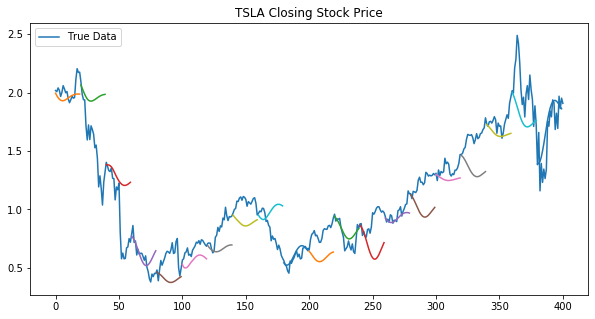

number correct: 8
number incorrect 11
percetage correct: 0.42105263157894735


In [1115]:
x_train, x_test, y_train,y_test, scalerX,scalerY= prepare_data('NVDA',seq_length, scalerX, scalerY )
predictions = predict_sequences_multiple(model, x_test, seq_length,20)
plot_results_multiple(predictions, y_test, 20, 'TSLA') 
correct , incorrect = n_day_accuracy(20, y_test, predictions)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

In [360]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']

In [629]:
stock_list2 = set_stock_list()
scalerX = preprocessing.PowerTransformer()
scalerY = preprocessing.PowerTransformer()

In [433]:
epochs = 4
stock_list = set_stock_list()
for i in range(0,100):
#for stock in stock_list:
    j = rand.randrange(0, len(stock_list)-1)
    print(stock_list[j])
    #print(stock)
    try:
        x_train,x_test,y_train,y_test, reverse, row = set_data(stock_list[j] , seq_length)
        #x_train,x_test,y_train,y_test, reverse, row = set_data(stock , seq_length)
        hist = model.fit(
                x_train,
                y_train,
                batch_size = 256,
                nb_epoch=epochs,
                validation_data=(x_test, y_test))
    except:
        print("not found")



SPCB
(3781, 31)
Train on 3592 samples, validate on 189 samples
Epoch 1/4
3592/3592 [==============================] - 0s 124us/step - loss: 0.0923 - val_loss: 0.0067
Epoch 2/4
3592/3592 [==============================] - 0s 124us/step - loss: 0.0980 - val_loss: 0.0068
Epoch 3/4
3592/3592 [==============================] - 0s 127us/step - loss: 0.0971 - val_loss: 0.0065
Epoch 4/4
3592/3592 [==============================] - 0s 125us/step - loss: 0.0936 - val_loss: 0.0066
AMHCW
(0,)
not found
DWSH
(410, 31)
Train on 390 samples, validate on 20 samples
Epoch 1/4
390/390 [==============================] - 0s 161us/step - loss: 0.0013 - val_loss: 0.0112
Epoch 2/4
390/390 [==============================] - 0s 166us/step - loss: 0.0016 - val_loss: 0.0109
Epoch 3/4
390/390 [==============================] - 0s 176us/step - loss: 0.0015 - val_loss: 0.0111
Epoch 4/4
390/390 [==============================] - 0s 174us/step - loss: 0.0012 - val_loss: 0.0109
CHMG
(5001, 31)
Train on 4751 samples, v

4751/4751 [==============================] - 1s 119us/step - loss: 0.0026 - val_loss: 8.9269e-04
ESGD
(920, 31)
Train on 874 samples, validate on 46 samples
Epoch 1/4
874/874 [==============================] - 0s 146us/step - loss: 2.0719e-04 - val_loss: 0.0011
Epoch 2/4
874/874 [==============================] - 0s 149us/step - loss: 2.0613e-04 - val_loss: 0.0011
Epoch 3/4
874/874 [==============================] - 0s 147us/step - loss: 2.8183e-04 - val_loss: 0.0018
Epoch 4/4
874/874 [==============================] - 0s 149us/step - loss: 2.6098e-04 - val_loss: 0.0013
CHMG
(5001, 31)
Train on 4751 samples, validate on 250 samples
Epoch 1/4
4751/4751 [==============================] - 1s 121us/step - loss: 7.1879e-04 - val_loss: 9.6387e-04
Epoch 2/4
4751/4751 [==============================] - 1s 123us/step - loss: 6.4423e-04 - val_loss: 0.0011
Epoch 3/4
4751/4751 [==============================] - 1s 123us/step - loss: 7.4152e-04 - val_loss: 0.0011
Epoch 4/4
4751/4751 [==============

Epoch 3/4
4567/4567 [==============================] - 1s 120us/step - loss: 9.6480e-04 - val_loss: 0.0011
Epoch 4/4
4567/4567 [==============================] - 1s 115us/step - loss: 9.9611e-04 - val_loss: 0.0012
FCAP
(5001, 31)
Train on 4751 samples, validate on 250 samples
Epoch 1/4
4751/4751 [==============================] - 1s 123us/step - loss: 8.7835e-04 - val_loss: 9.3692e-04
Epoch 2/4
4751/4751 [==============================] - 1s 120us/step - loss: 8.7782e-04 - val_loss: 8.2390e-04
Epoch 3/4
4751/4751 [==============================] - 1s 119us/step - loss: 8.5602e-04 - val_loss: 8.1552e-04
Epoch 4/4
4751/4751 [==============================] - 1s 119us/step - loss: 8.3341e-04 - val_loss: 8.3034e-04
UNTY
(5001, 31)
Train on 4751 samples, validate on 250 samples
Epoch 1/4
4751/4751 [==============================] - 1s 120us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 2/4
4751/4751 [==============================] - 1s 124us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 3/4


Epoch 3/4
1998/1998 [==============================] - 0s 118us/step - loss: 0.5049 - val_loss: 0.0040
Epoch 4/4
1998/1998 [==============================] - 0s 122us/step - loss: 0.4732 - val_loss: 0.0041
USAU
(4989, 31)
Train on 4740 samples, validate on 249 samples
Epoch 1/4
4740/4740 [==============================] - 1s 116us/step - loss: 0.0450 - val_loss: 0.2806
Epoch 2/4
4740/4740 [==============================] - 1s 116us/step - loss: 0.0561 - val_loss: 0.2784
Epoch 3/4
4740/4740 [==============================] - 1s 116us/step - loss: 0.0338 - val_loss: 0.2835
Epoch 4/4
4740/4740 [==============================] - 1s 114us/step - loss: 0.0335 - val_loss: 0.2912
CY
(5001, 31)
Train on 4751 samples, validate on 250 samples
Epoch 1/4
4751/4751 [==============================] - 1s 113us/step - loss: 0.0039 - val_loss: 0.0013
Epoch 2/4
4751/4751 [==============================] - 1s 115us/step - loss: 0.0039 - val_loss: 0.0012
Epoch 3/4
4751/4751 [==============================]

QIWI
(1716, 31)
Train on 1630 samples, validate on 86 samples
Epoch 1/4
1630/1630 [==============================] - 0s 124us/step - loss: 0.0040 - val_loss: 0.0023
Epoch 2/4
1630/1630 [==============================] - 0s 125us/step - loss: 0.0040 - val_loss: 0.0022
Epoch 3/4
1630/1630 [==============================] - 0s 125us/step - loss: 0.0041 - val_loss: 0.0020
Epoch 4/4
1630/1630 [==============================] - 0s 125us/step - loss: 0.0040 - val_loss: 0.0023
CLCT
(5001, 31)
Train on 4751 samples, validate on 250 samples
Epoch 1/4
4751/4751 [==============================] - 1s 114us/step - loss: 0.0179 - val_loss: 0.0011
Epoch 2/4
4751/4751 [==============================] - 1s 115us/step - loss: 0.0139 - val_loss: 0.0012
Epoch 3/4
4751/4751 [==============================] - 1s 117us/step - loss: 0.0168 - val_loss: 0.0014
Epoch 4/4
4751/4751 [==============================] - 1s 119us/step - loss: 0.0149 - val_loss: 0.0014
ZBRA
(5001, 31)
Train on 4751 samples, validate on 

ZM
(216, 31)
Train on 205 samples, validate on 11 samples
Epoch 1/4
205/205 [==============================] - 0s 165us/step - loss: 0.0065 - val_loss: 0.0069
Epoch 2/4
205/205 [==============================] - 0s 161us/step - loss: 0.0070 - val_loss: 0.0063
Epoch 3/4
205/205 [==============================] - 0s 165us/step - loss: 0.0072 - val_loss: 0.0065
Epoch 4/4
205/205 [==============================] - 0s 165us/step - loss: 0.0081 - val_loss: 0.0063
CRSP
(843, 31)
Train on 801 samples, validate on 42 samples
Epoch 1/4
801/801 [==============================] - 0s 152us/step - loss: 0.0069 - val_loss: 0.0026
Epoch 2/4
801/801 [==============================] - 0s 149us/step - loss: 0.0086 - val_loss: 0.0032
Epoch 3/4
801/801 [==============================] - 0s 148us/step - loss: 0.0078 - val_loss: 0.0020
Epoch 4/4
801/801 [==============================] - 0s 149us/step - loss: 0.0077 - val_loss: 0.0030
PRSC
(4158, 31)
Train on 3950 samples, validate on 208 samples
Epoch 1/4
3

In [434]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('TCCO',seq_length)
#x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
#x_train,x_test,y_train,y_test, scalerX, scalerY = prepare_data( stock_list[j], seq_length, scalerX, scalerY)

(5001, 31)


In [435]:
predicted = predict_point_by_point(model, x_test)
true_graph = reverse_normalise(y_test, for_reverse,row)
predicted_graph = reverse_normalise(predicted, for_reverse, row)
mse(y_test,predicted)


0.03193029607041157

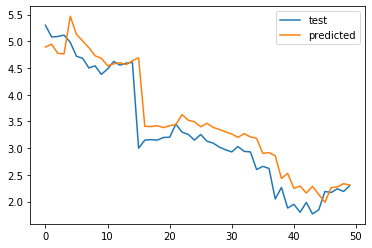

In [436]:
plt.plot(true_graph[200:], label = "test")
plt.plot(predicted_graph[200:], label = "predicted")
plt.legend()
plt.show()

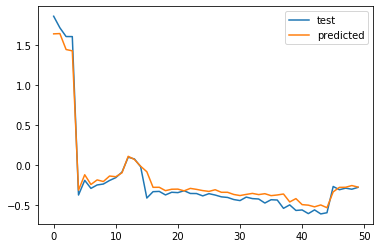

In [437]:
plt.plot(y_test[200:], label = "test")
plt.plot(predicted[200:], label = "predicted")
plt.legend()
plt.show()

In [438]:
correct , incorrect= accuracy(y_test, predicted)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

number correct: 159
number incorrect 90
percetage correct: 0.6385542168674698


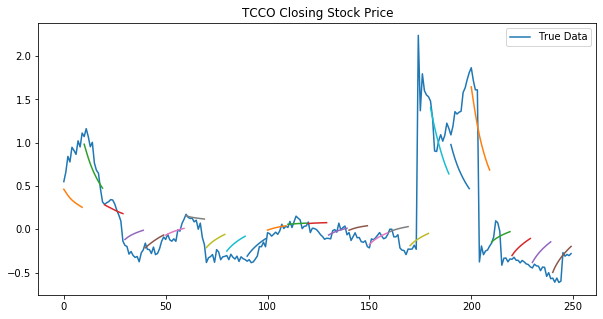

In [439]:
predictions = predict_sequences_multiple(model, x_test, seq_length,10)
plot_results_multiple(predictions, y_test, 10, 'TCCO') 

In [440]:
correct , incorrect = n_day_accuracy(10, y_test, predictions)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

number correct: 13
number incorrect 9
percetage correct: 0.5909090909090909


In [441]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']

In [442]:
best = 0.0000001
average = 0
length = 0

(5001, 31)


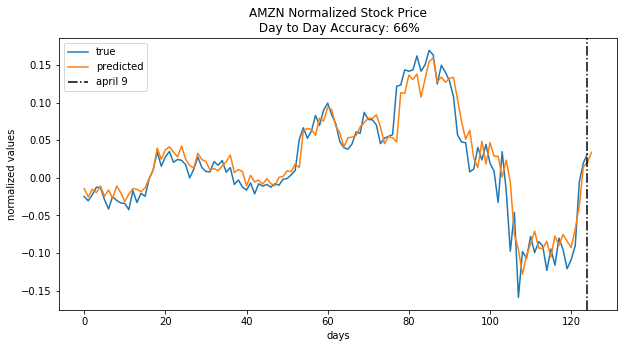

(5001, 31)


<Figure size 432x288 with 0 Axes>

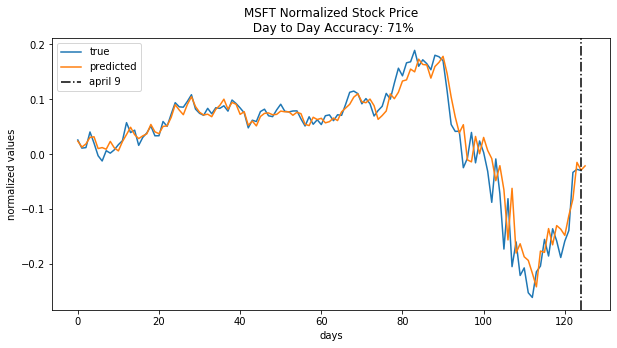

(3907, 31)


<Figure size 432x288 with 0 Axes>

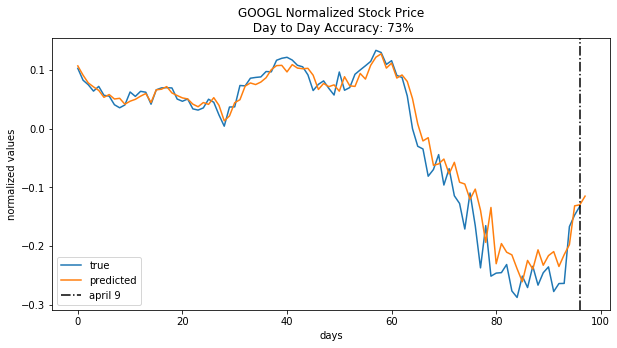

(5001, 31)


<Figure size 432x288 with 0 Axes>

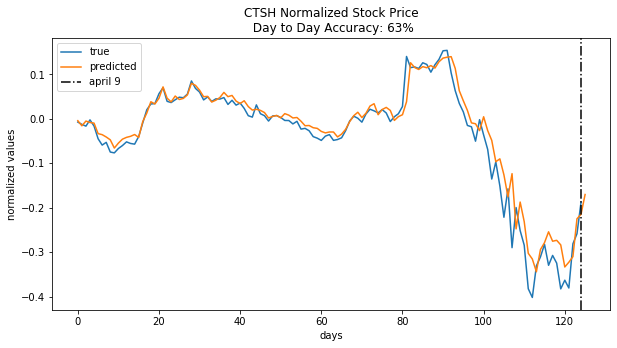

(5001, 31)


<Figure size 432x288 with 0 Axes>

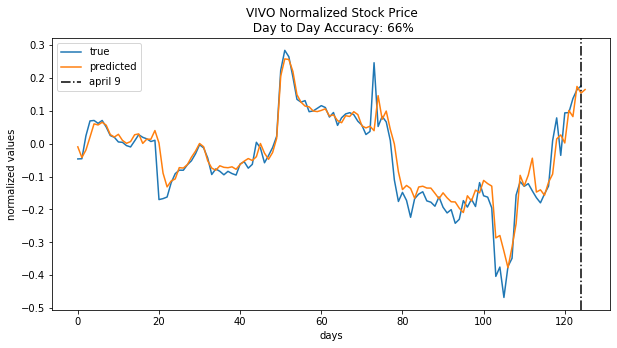

(5002, 31)


<Figure size 432x288 with 0 Axes>

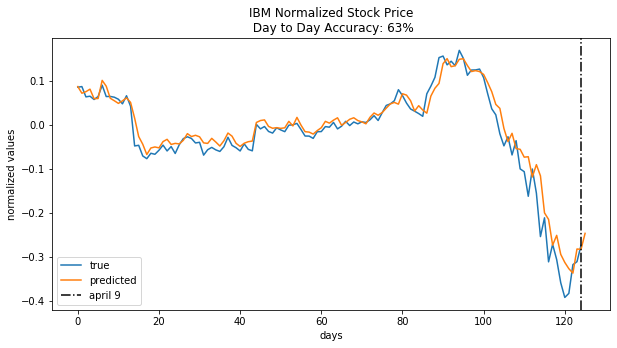

(5001, 31)


<Figure size 432x288 with 0 Axes>

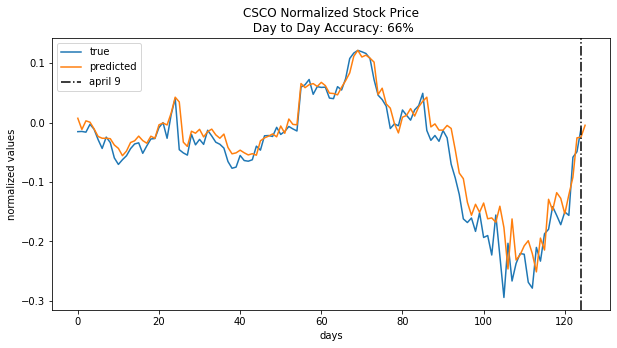

(5001, 31)


<Figure size 432x288 with 0 Axes>

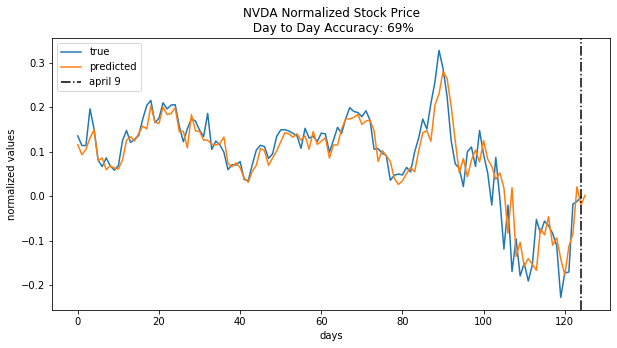

(5001, 31)


<Figure size 432x288 with 0 Axes>

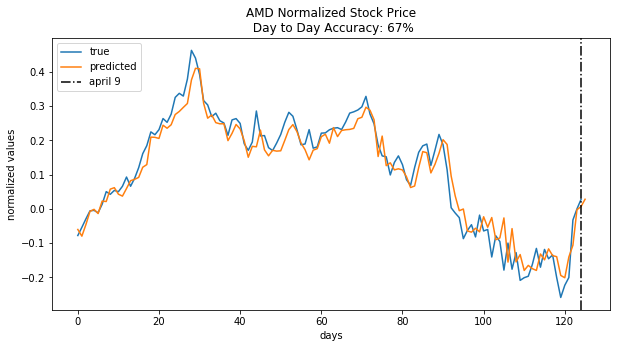

(5001, 31)


<Figure size 432x288 with 0 Axes>

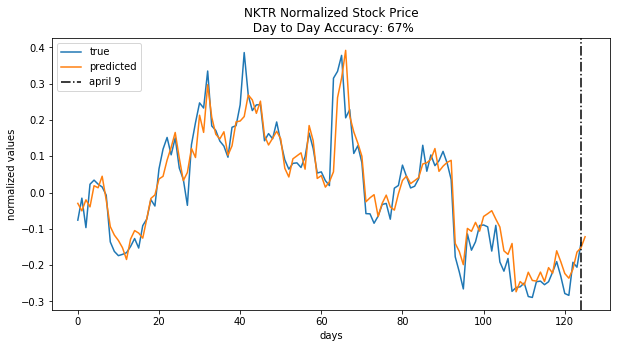

(5002, 31)


<Figure size 432x288 with 0 Axes>

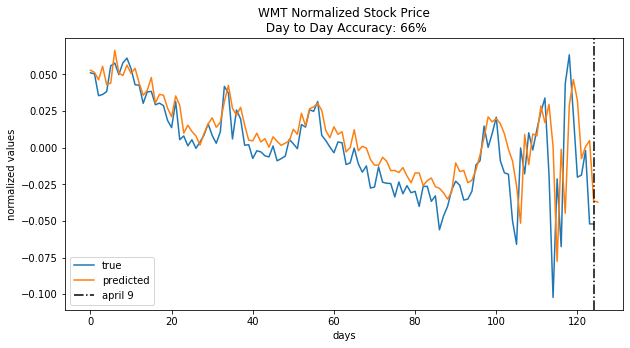

(5001, 31)


<Figure size 432x288 with 0 Axes>

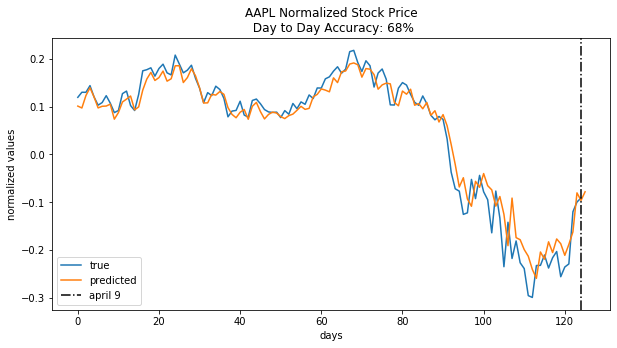

(5002, 31)


<Figure size 432x288 with 0 Axes>

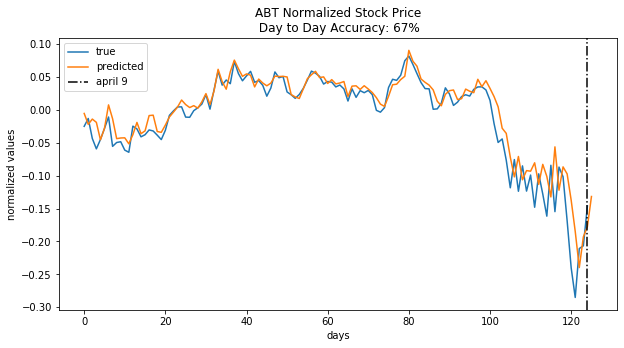

(4671, 31)


<Figure size 432x288 with 0 Axes>

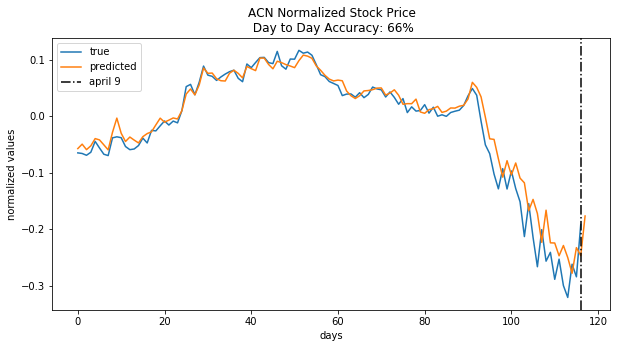

(5001, 31)


<Figure size 432x288 with 0 Axes>

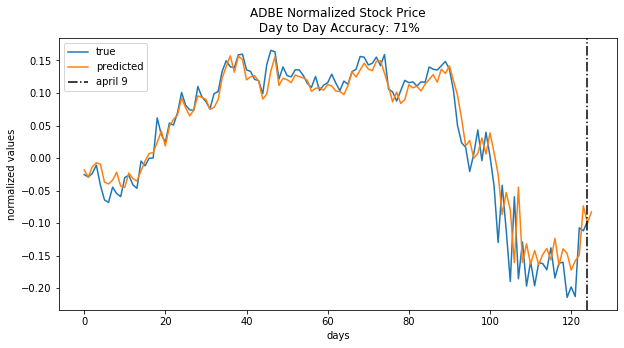

(5002, 31)


<Figure size 432x288 with 0 Axes>

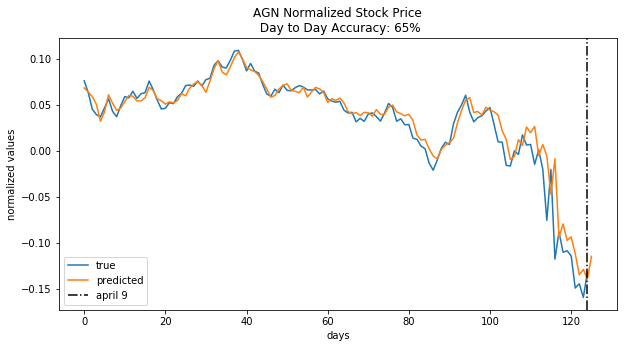

(5002, 31)


<Figure size 432x288 with 0 Axes>

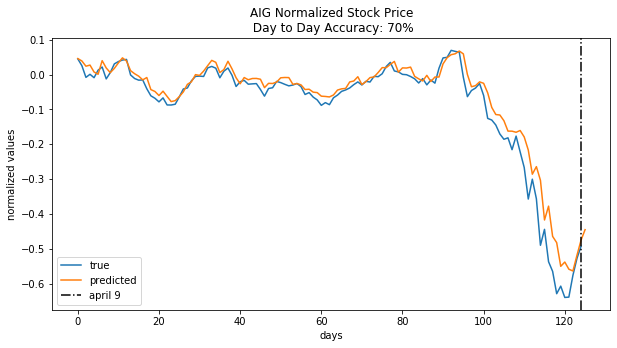

(5002, 31)


<Figure size 432x288 with 0 Axes>

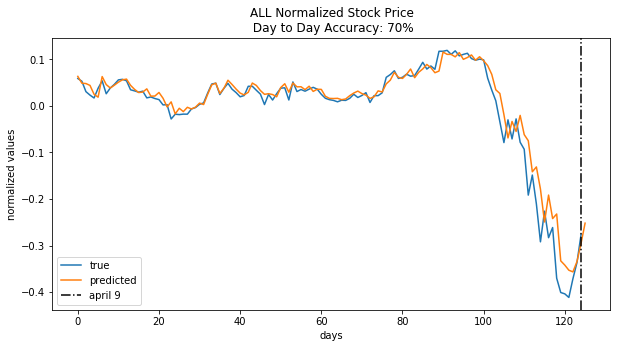

(5001, 31)


<Figure size 432x288 with 0 Axes>

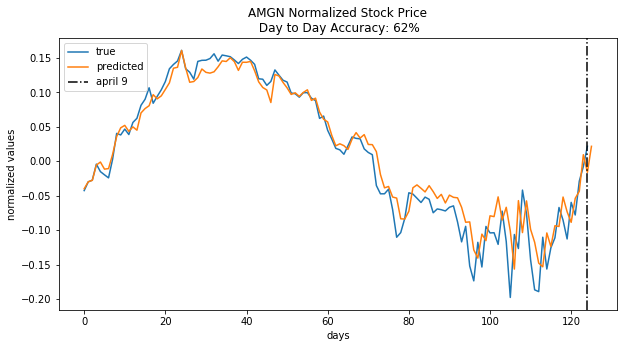

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

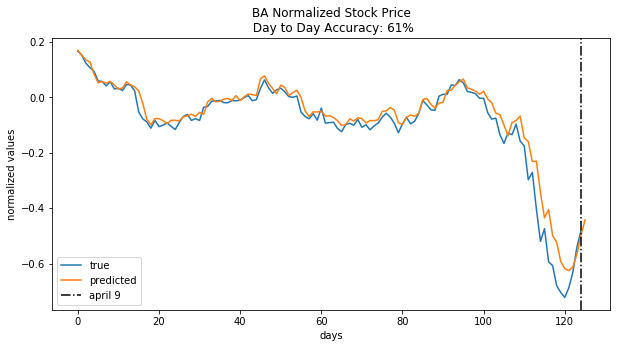

(5002, 31)


<Figure size 432x288 with 0 Axes>

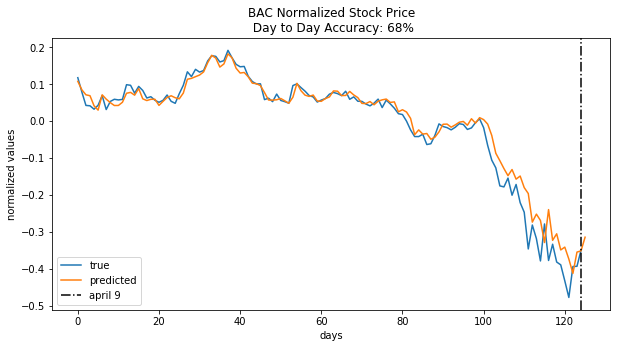

(5001, 31)


<Figure size 432x288 with 0 Axes>

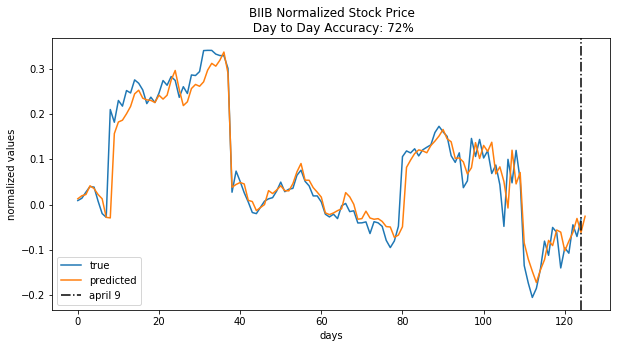

(5002, 31)


<Figure size 432x288 with 0 Axes>

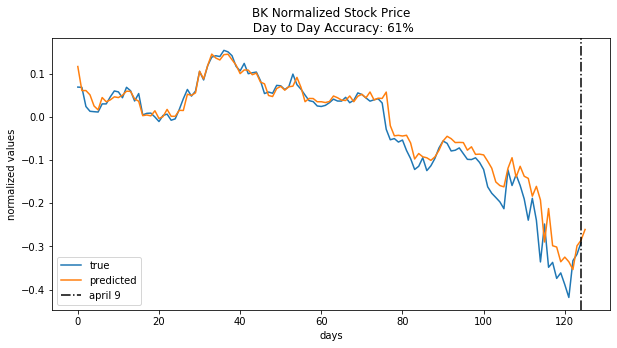

(5002, 31)


<Figure size 432x288 with 0 Axes>

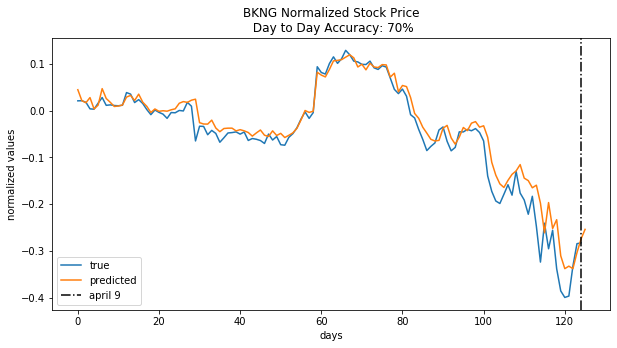

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

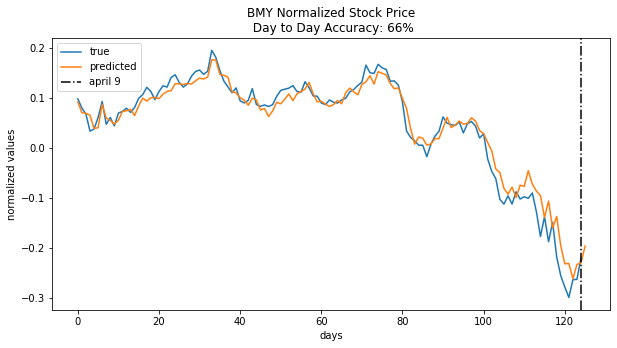

(5002, 31)


<Figure size 432x288 with 0 Axes>

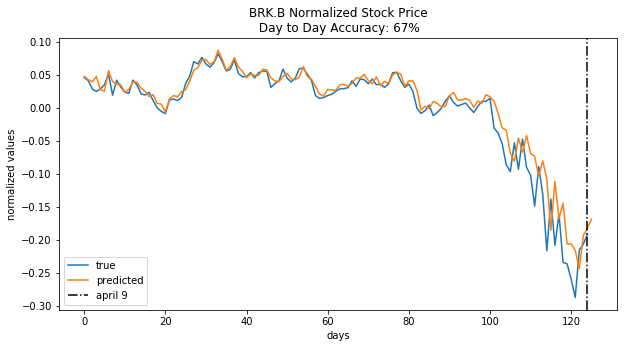

(5002, 31)


<Figure size 432x288 with 0 Axes>

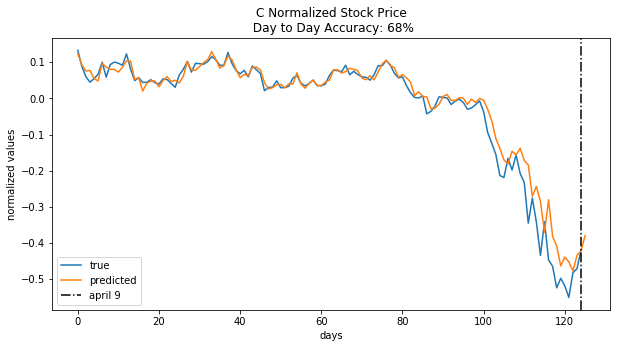

(5002, 31)


<Figure size 432x288 with 0 Axes>

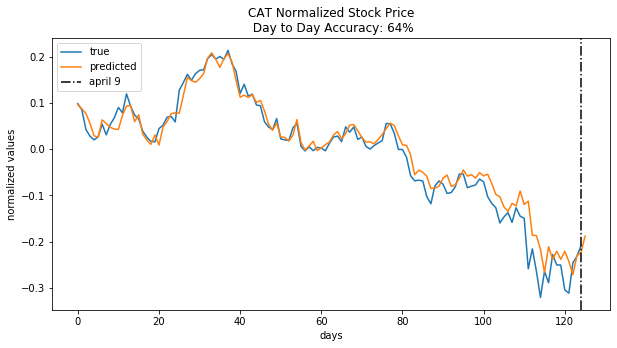

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

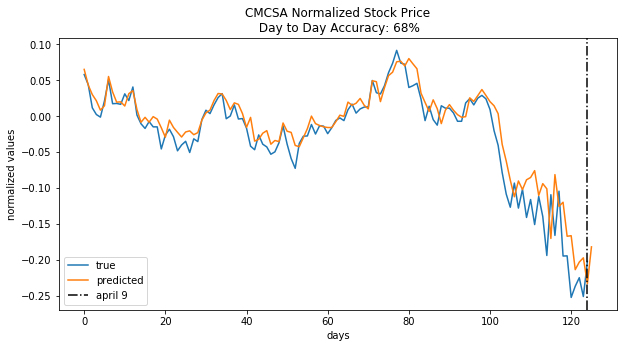

(5002, 31)


<Figure size 432x288 with 0 Axes>

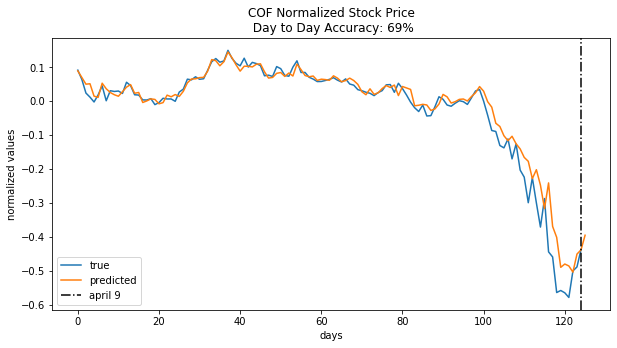

(5001, 31)


<Figure size 432x288 with 0 Axes>

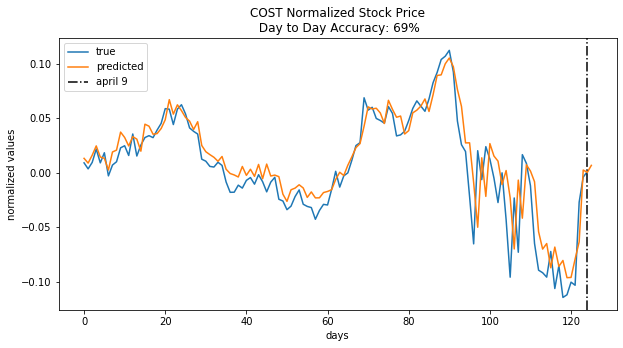

(5002, 31)


<Figure size 432x288 with 0 Axes>

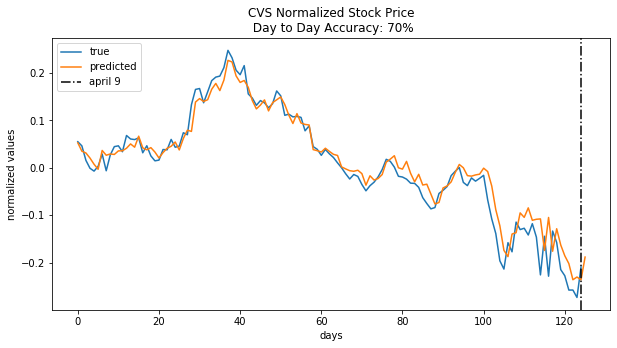

not found
(177, 31)


<Figure size 432x288 with 0 Axes>

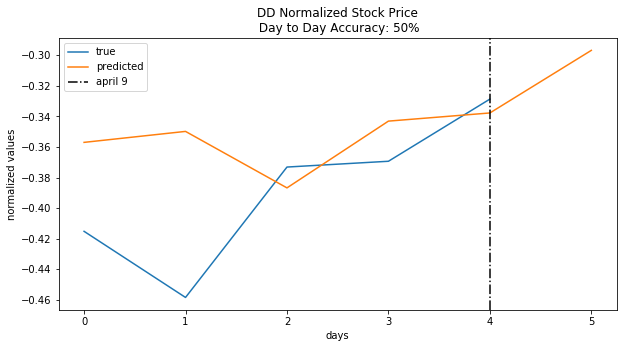

(5002, 31)


<Figure size 432x288 with 0 Axes>

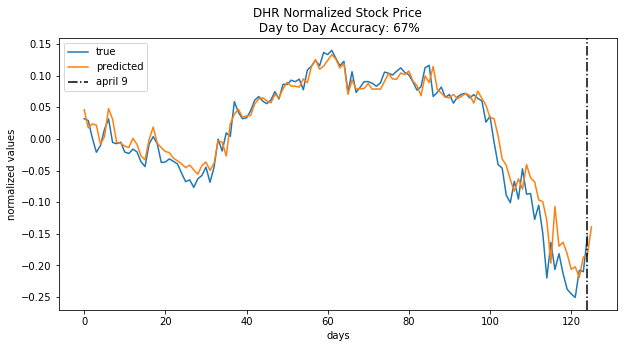

(5002, 31)


<Figure size 432x288 with 0 Axes>

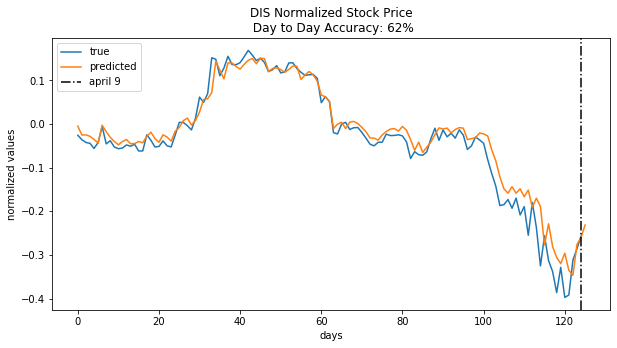

(5002, 31)


<Figure size 432x288 with 0 Axes>

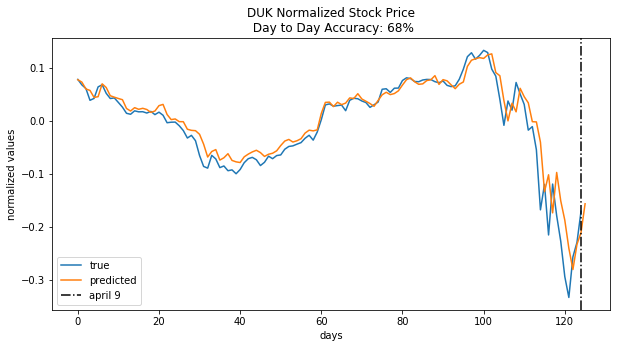

not found
(5001, 31)


<Figure size 432x288 with 0 Axes>

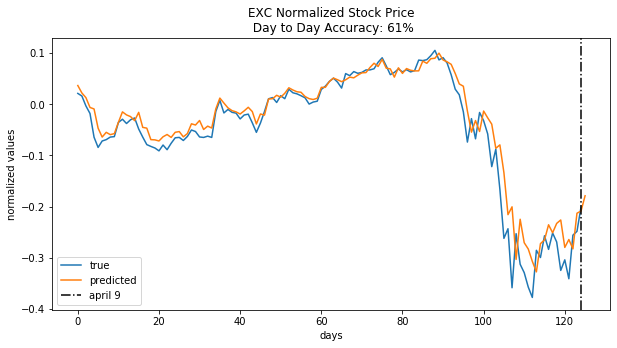

(5002, 31)


<Figure size 432x288 with 0 Axes>

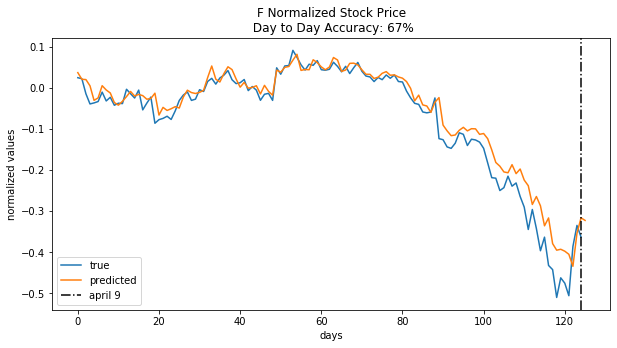

(1946, 31)


<Figure size 432x288 with 0 Axes>

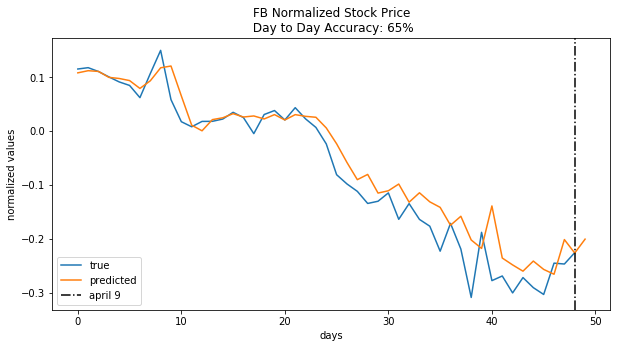

(5002, 31)


<Figure size 432x288 with 0 Axes>

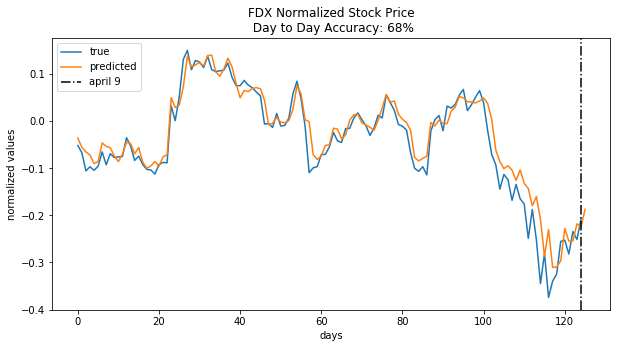

(5002, 31)


<Figure size 432x288 with 0 Axes>

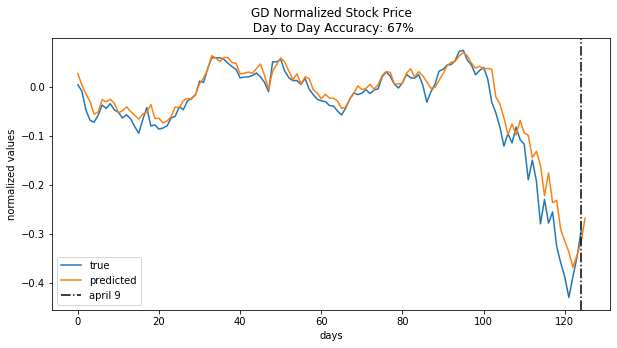

not found
(5001, 31)


<Figure size 432x288 with 0 Axes>

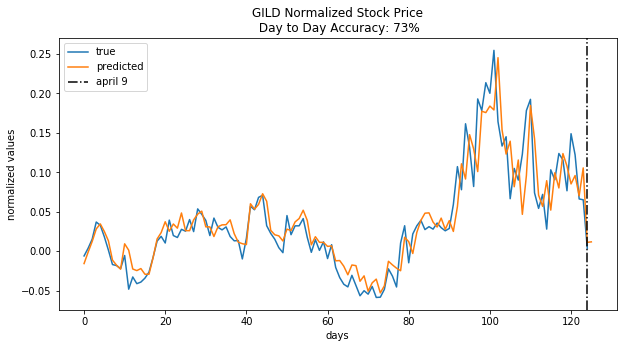

(2323, 31)


<Figure size 432x288 with 0 Axes>

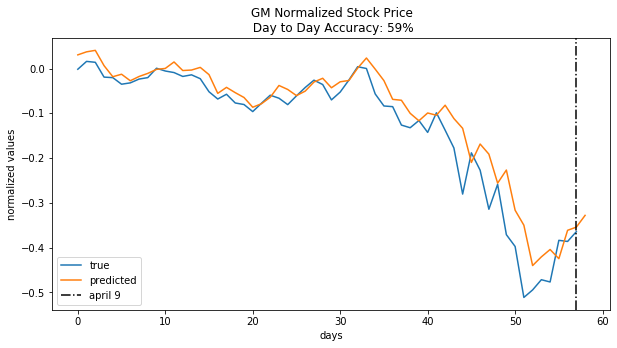

(1490, 31)


<Figure size 432x288 with 0 Axes>

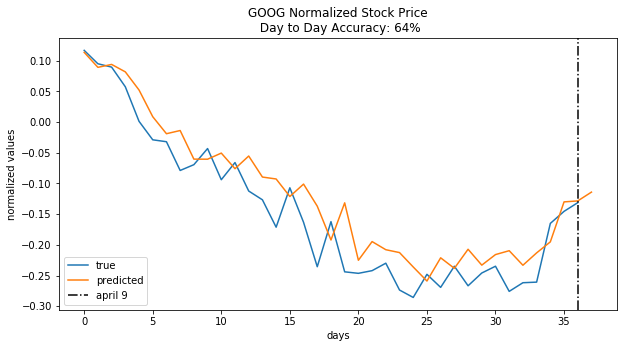

(5002, 31)


<Figure size 432x288 with 0 Axes>

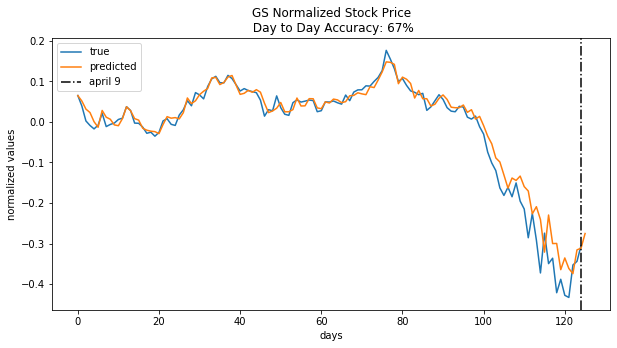

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

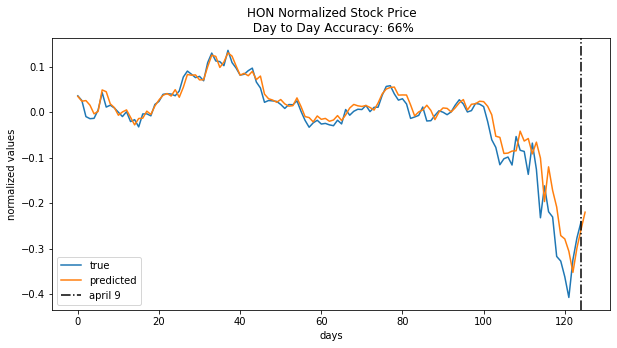

(5002, 31)


<Figure size 432x288 with 0 Axes>

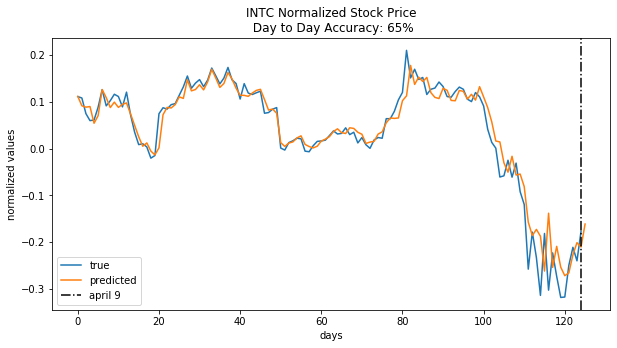

(5002, 31)


<Figure size 432x288 with 0 Axes>

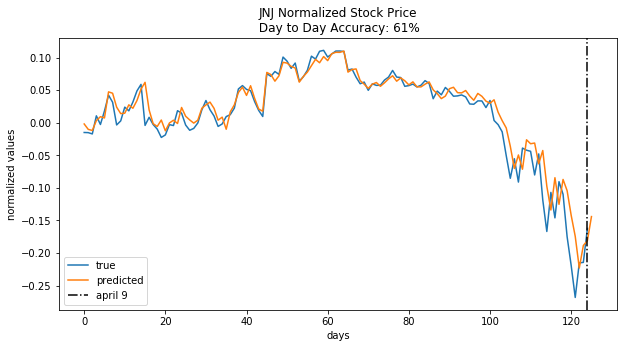

(5002, 31)


<Figure size 432x288 with 0 Axes>

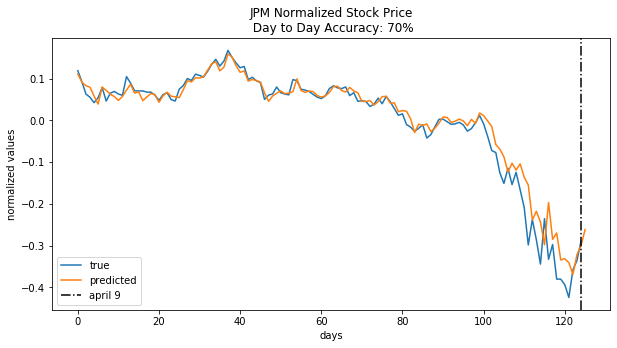

(1170, 31)


<Figure size 432x288 with 0 Axes>

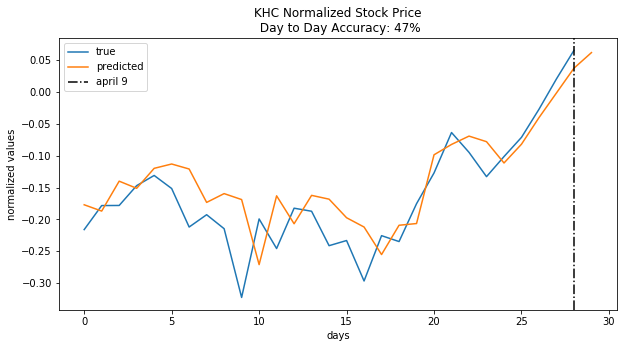

(2265, 31)


<Figure size 432x288 with 0 Axes>

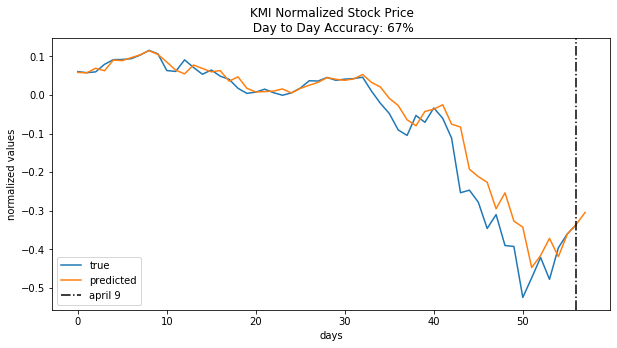

(5002, 31)


<Figure size 432x288 with 0 Axes>

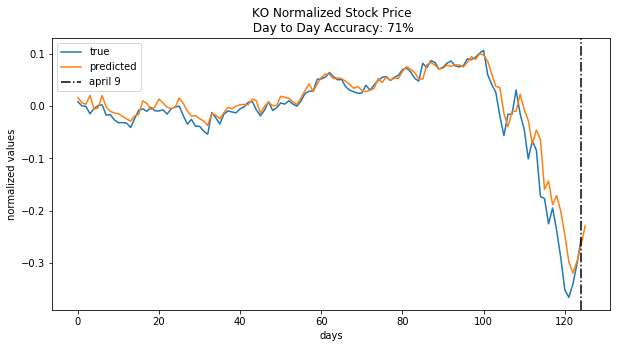

(5002, 31)


<Figure size 432x288 with 0 Axes>

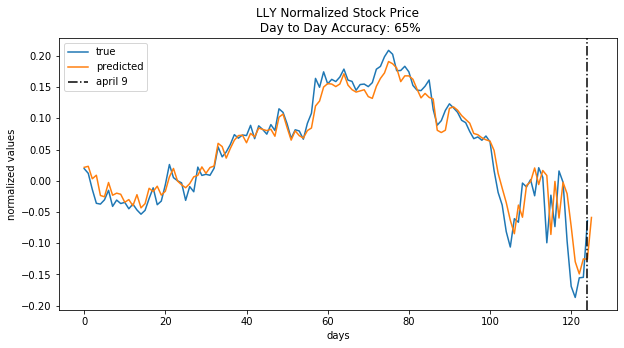

(5002, 31)


<Figure size 432x288 with 0 Axes>

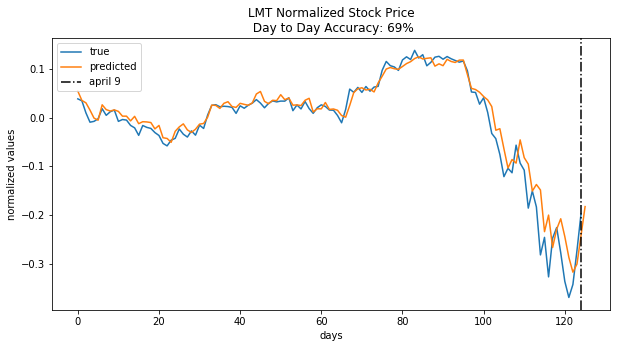

(5002, 31)


<Figure size 432x288 with 0 Axes>

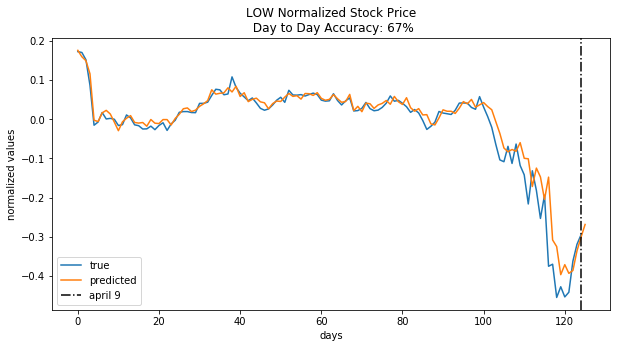

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

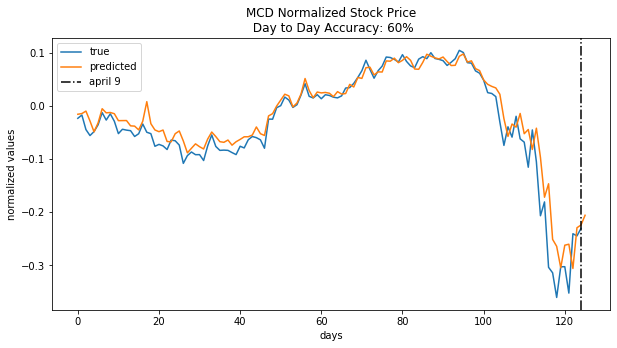

(4705, 31)


<Figure size 432x288 with 0 Axes>

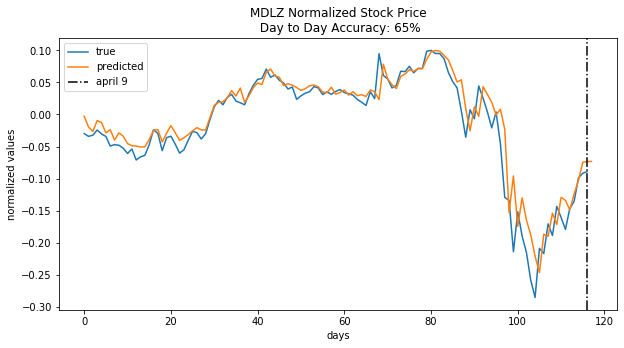

(5002, 31)


<Figure size 432x288 with 0 Axes>

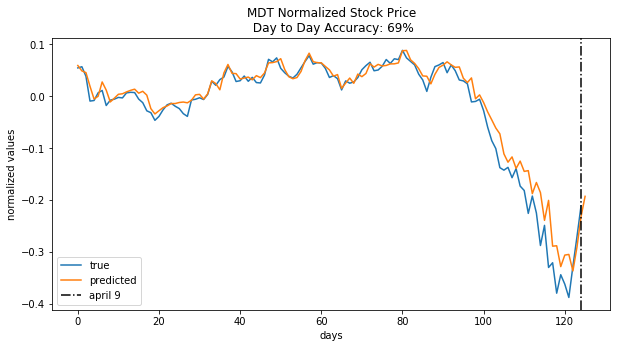

(4995, 31)


<Figure size 432x288 with 0 Axes>

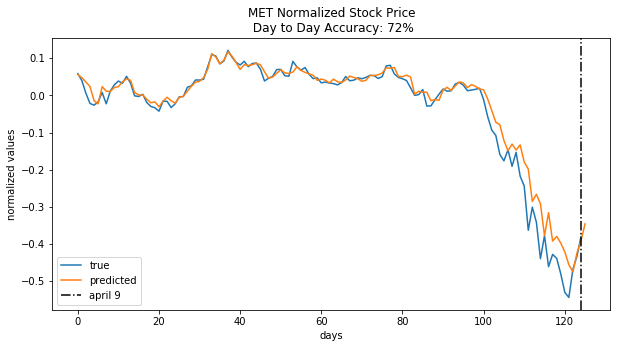

(5002, 31)


<Figure size 432x288 with 0 Axes>

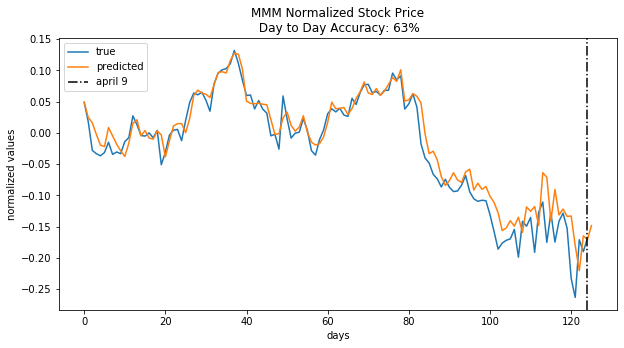

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

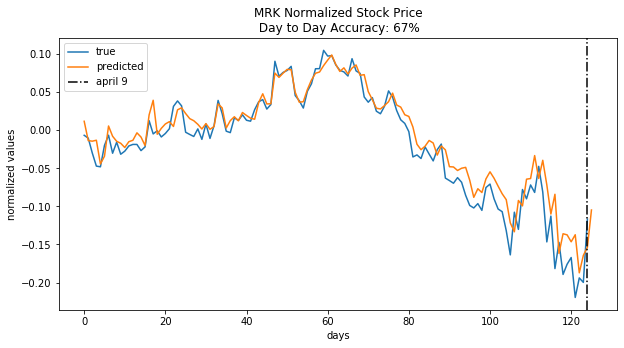

(5002, 31)


<Figure size 432x288 with 0 Axes>

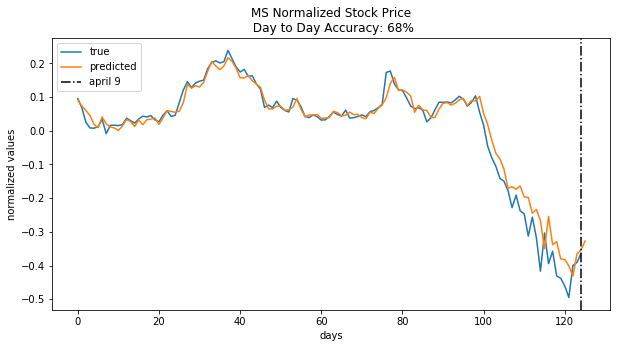

(5002, 31)


<Figure size 432x288 with 0 Axes>

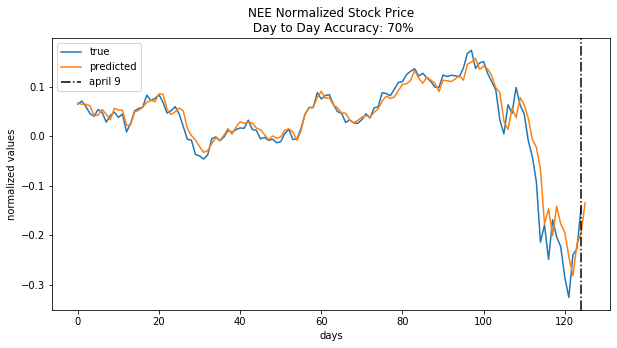

(4471, 31)


<Figure size 432x288 with 0 Axes>

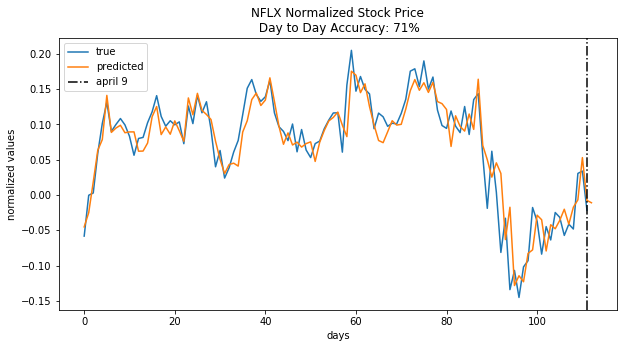

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

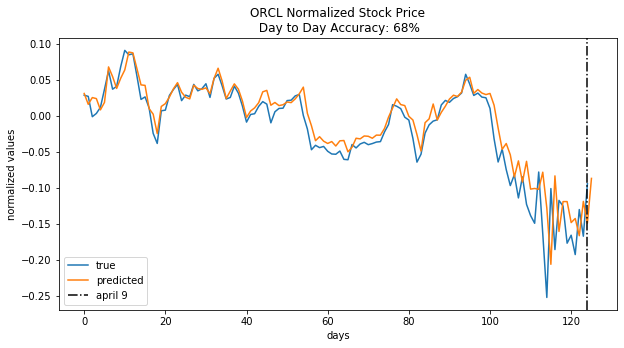

(5002, 31)


<Figure size 432x288 with 0 Axes>

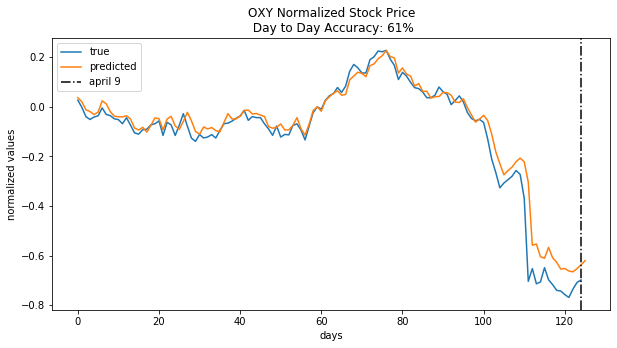

(5001, 31)


<Figure size 432x288 with 0 Axes>

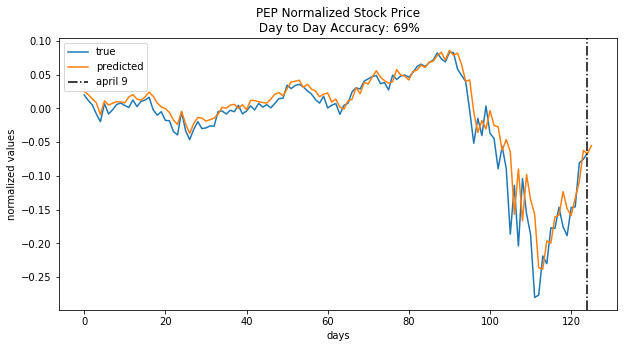

(5002, 31)


<Figure size 432x288 with 0 Axes>

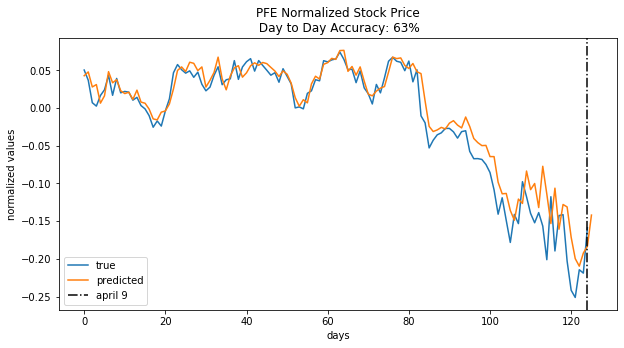

not found
(2999, 31)


<Figure size 432x288 with 0 Axes>

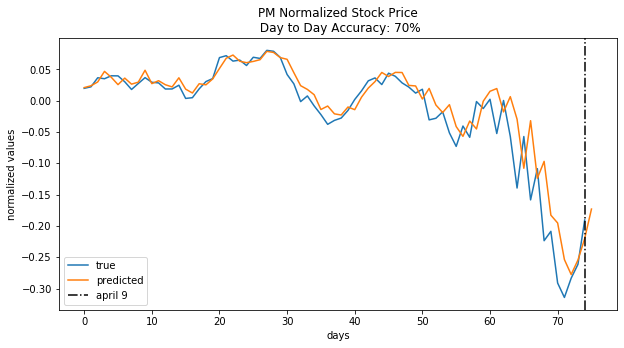

(1160, 31)


<Figure size 432x288 with 0 Axes>

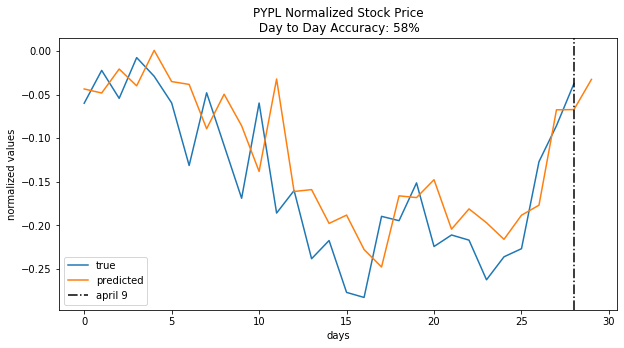

(5001, 31)


<Figure size 432x288 with 0 Axes>

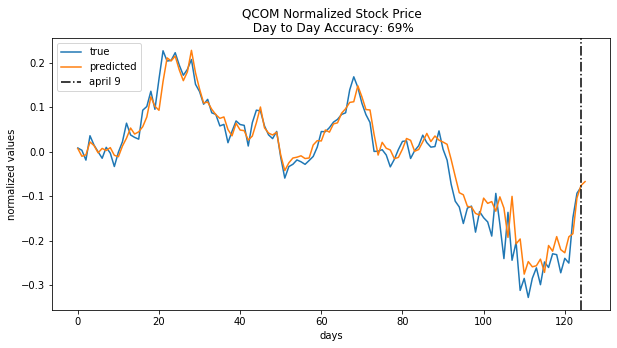

(5002, 31)


<Figure size 432x288 with 0 Axes>

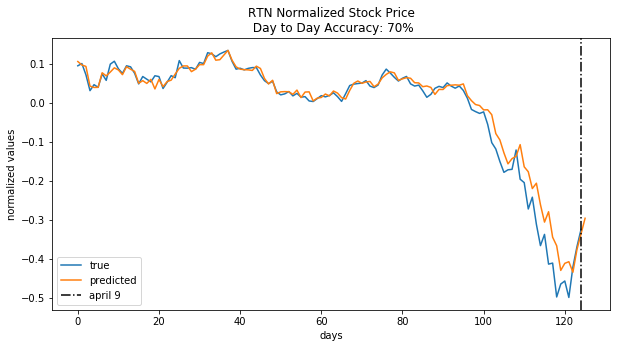

(5001, 31)


<Figure size 432x288 with 0 Axes>

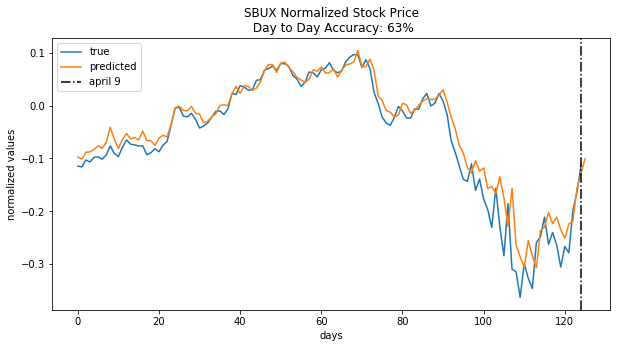

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

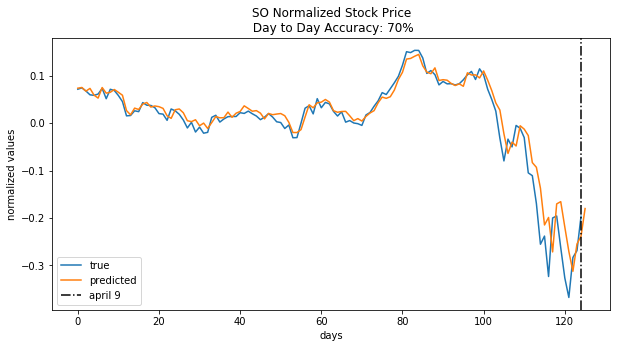

(5002, 31)


<Figure size 432x288 with 0 Axes>

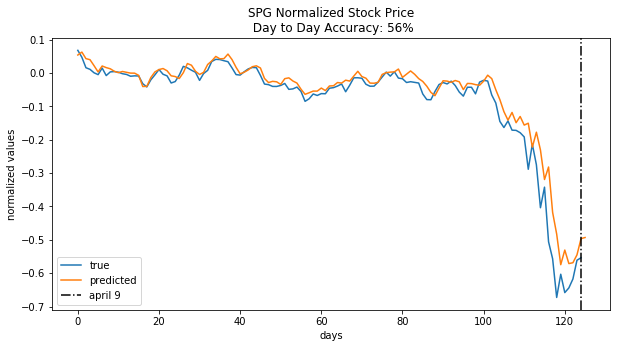

(5002, 31)


<Figure size 432x288 with 0 Axes>

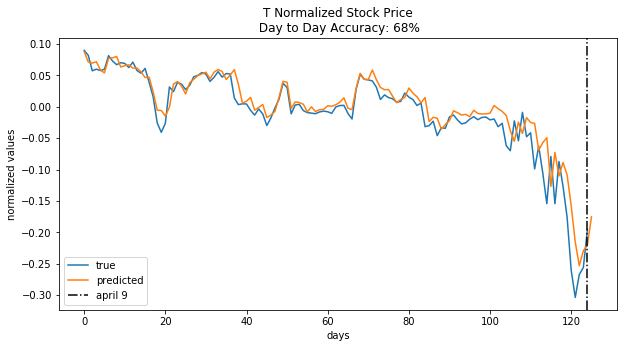

(5002, 31)


<Figure size 432x288 with 0 Axes>

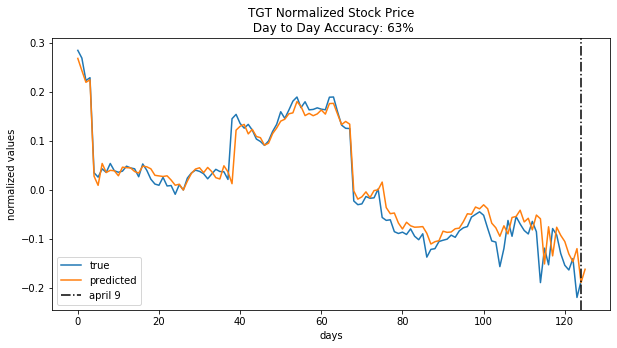

(5002, 31)


<Figure size 432x288 with 0 Axes>

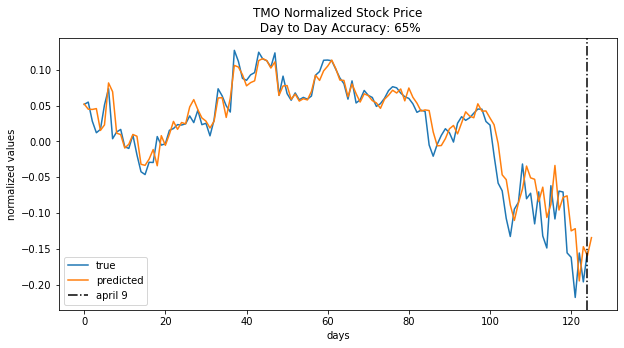

(5001, 31)


<Figure size 432x288 with 0 Axes>

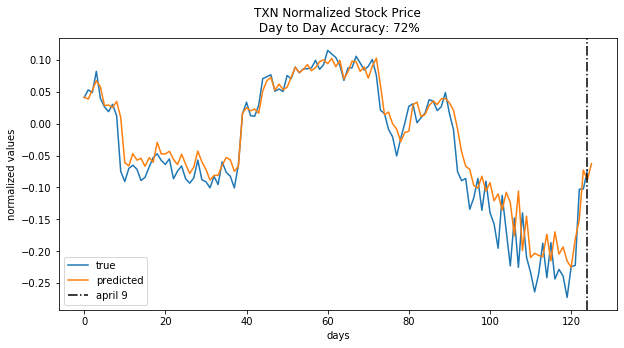

(5002, 31)


<Figure size 432x288 with 0 Axes>

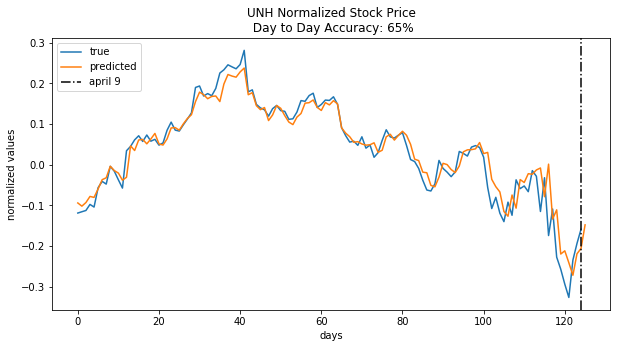

(5002, 31)


<Figure size 432x288 with 0 Axes>

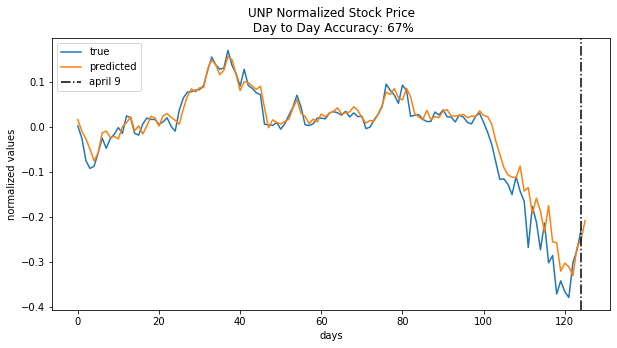

(5002, 31)


<Figure size 432x288 with 0 Axes>

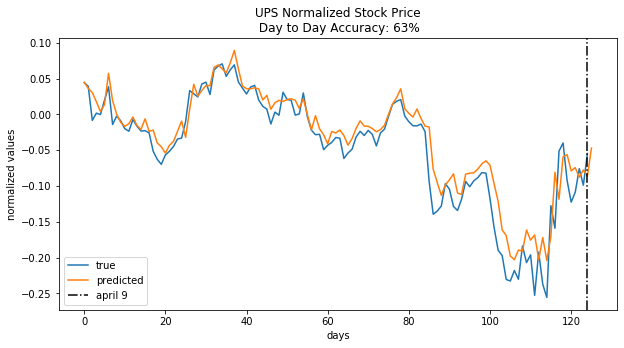

(5002, 31)


<Figure size 432x288 with 0 Axes>

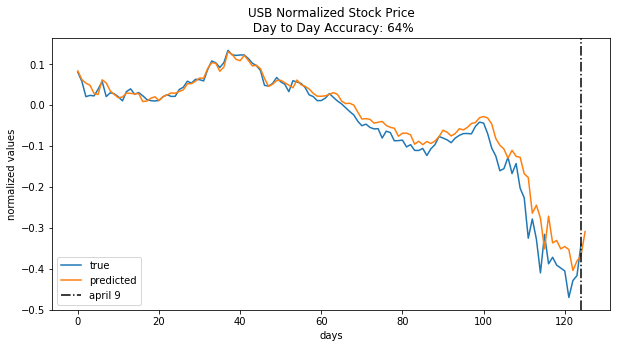

(5002, 31)


<Figure size 432x288 with 0 Axes>

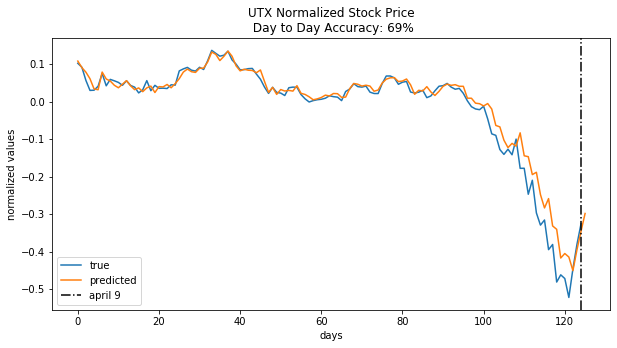

not found
(5002, 31)


<Figure size 432x288 with 0 Axes>

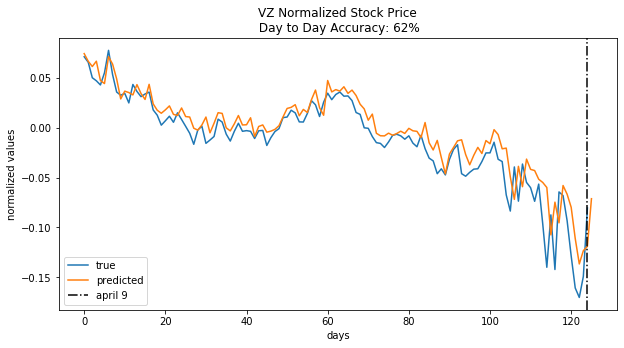

(5001, 31)


<Figure size 432x288 with 0 Axes>

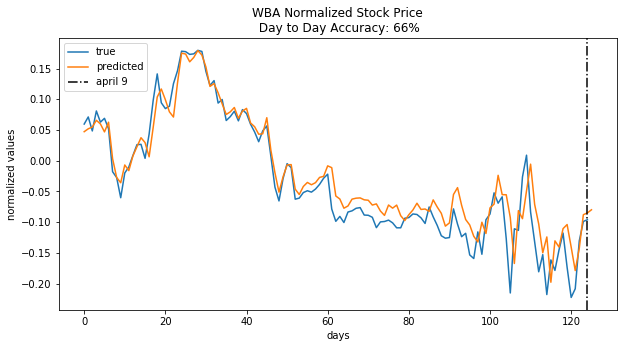

(5002, 31)


<Figure size 432x288 with 0 Axes>

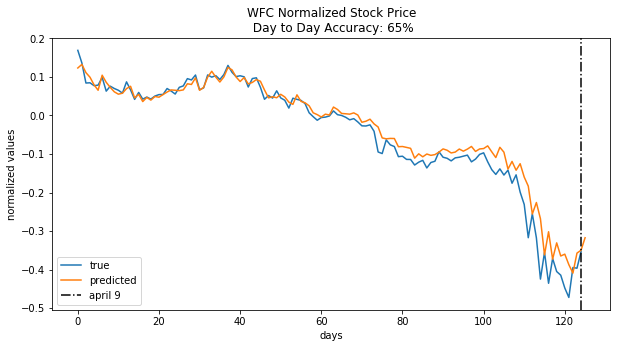

(5002, 31)


<Figure size 432x288 with 0 Axes>

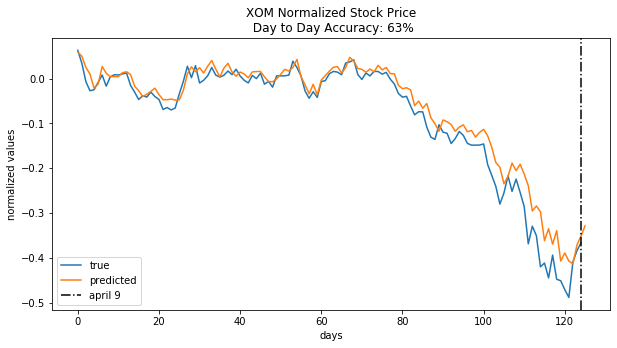

best stock: GILD
score:  0.7309236947791165
average:  0.6610177889701515


<Figure size 432x288 with 0 Axes>

In [443]:
#10 works best
#stock_list1 = set_stock_list()
for stock in stock_list1:
    try:
        x_train,x_test,y_train,y_test, for_reverse, row = set_data(stock , seq_length)
        #x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
        predicted = predict_point_by_point(model, x_test)        
        correct , incorrect = accuracy(y_test, predicted)
        new = []
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        predicted = np.append(predicted,newPredicted)
        shown_val = round(len(y_test) *.5)  
        stock_acc = round(float(correct/(correct+incorrect))*100) 
        plt.figure(figsize = (10,5))
        plt.plot(y_test[shown_val:], label = 'true')
        plt.plot(predicted[shown_val:], label = 'predicted')
        plt.axvline(len(y_test[shown_val:])-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
        plt.xlabel('days')
        plt.ylabel('normalized values')
        plt.title(stock + " Normalized Stock Price\n Day to Day Accuracy: " + str(stock_acc)+ "%")
        plt.legend()
        #plt.savefig("../1dayPredictions/" + stock +".png")
        plt.show()
        plt.clf()
        average = average + float(correct/(correct+incorrect))
        length = length + 1
        if float(correct/(correct+incorrect)) > best:
            best = float(correct/(correct+incorrect))
            best_stock = stock
            
    except:
        print("not found")
print("best stock:",best_stock)
print("score: ",best)
print("average: ", float(average/length))

In [444]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH',
               'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [445]:
days = 10

(5001, 31)


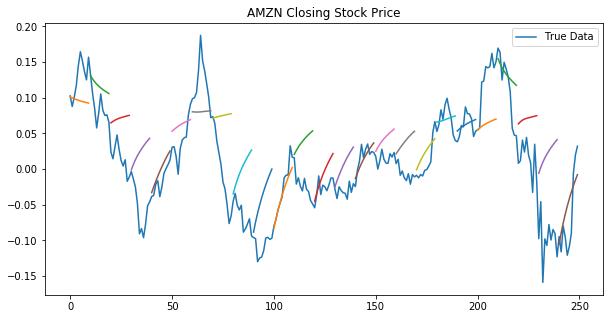

AMZN
number correct: 16
number incorrect 6
percetage correct: 0.7272727272727273
(5001, 31)


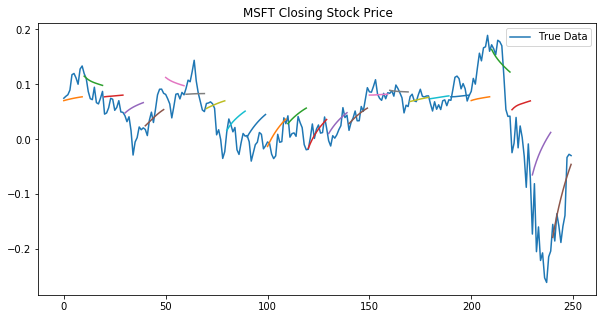

MSFT
number correct: 15
number incorrect 7
percetage correct: 0.6818181818181818
(3907, 31)


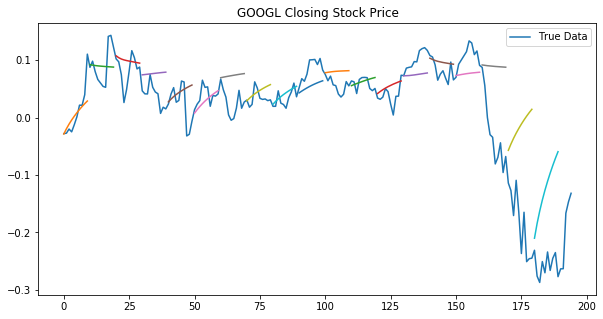

GOOGL
number correct: 13
number incorrect 4
percetage correct: 0.7647058823529411
(5001, 31)


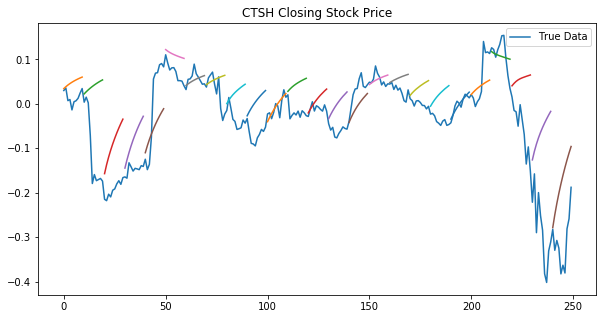

CTSH
number correct: 12
number incorrect 10
percetage correct: 0.5454545454545454
(5001, 31)


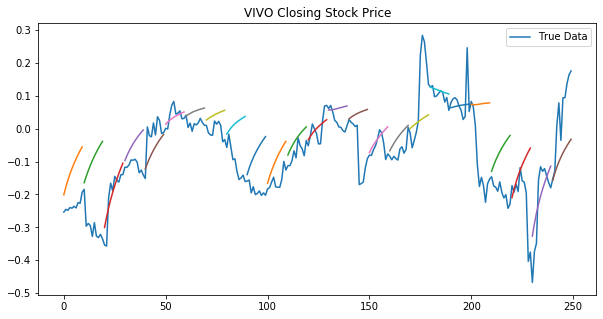

VIVO
number correct: 14
number incorrect 8
percetage correct: 0.6363636363636364
(5002, 31)


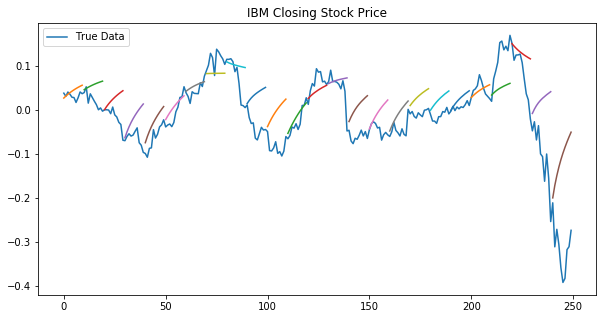

IBM
number correct: 13
number incorrect 9
percetage correct: 0.5909090909090909
(5001, 31)


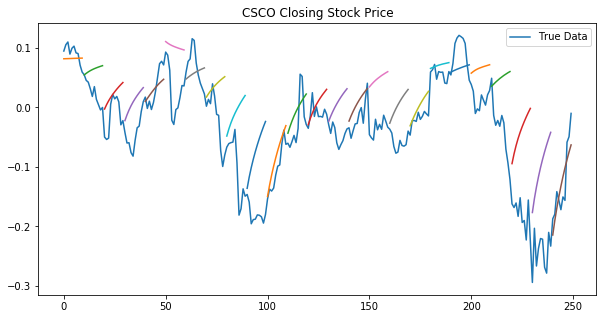

CSCO
number correct: 11
number incorrect 11
percetage correct: 0.5
(5001, 31)


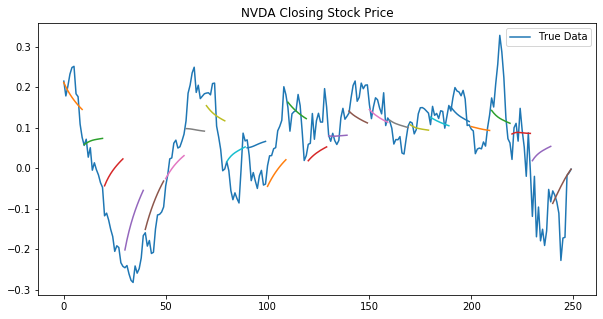

NVDA
number correct: 13
number incorrect 9
percetage correct: 0.5909090909090909
(5001, 31)


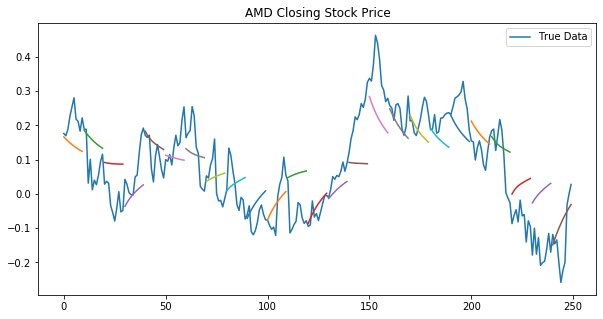

AMD
number correct: 11
number incorrect 11
percetage correct: 0.5
(5001, 31)


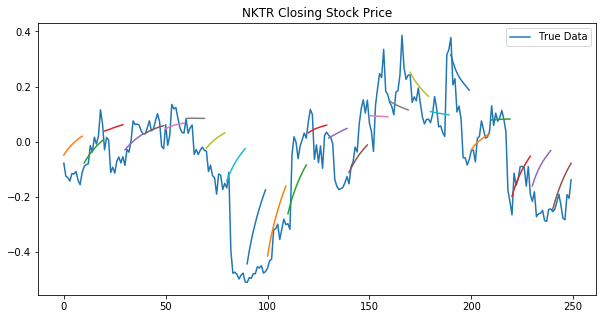

NKTR
number correct: 12
number incorrect 10
percetage correct: 0.5454545454545454
(5002, 31)


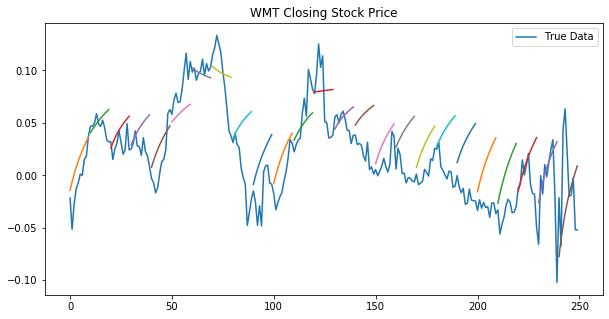

WMT
number correct: 10
number incorrect 12
percetage correct: 0.45454545454545453


In [446]:
for stock in stock_list1:
    try:
        x_train,x_test,y_train,y_test, result, row = set_data(stock , seq_length)
        #x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
        predictions = predict_sequences_multiple(model, x_test, seq_length,days)
        plot_results_multiple(predictions, y_test,days, stock) 
        correct , incorrect= n_day_accuracy(days, y_test, predictions)
        print(stock)
        print("number correct:", correct)
        print("number incorrect", incorrect)
        print("percetage correct:", float(correct/(correct+incorrect)))
    except:
        print("not found")

In [1116]:
model.save('bestsing.h5')

In [970]:
model = load_model('bestsingLog.h5')


In [ ]:
def predict_future(days, model , x_test, y_test, seq_len):
        prev_predicted = predict_point_by_point(model, x_test)
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        prev_predicted = np.append(prev_predicted,newPredicted)
        for i in range(2,days+1):
            if i < seq_len:
                new = x_test[-1][i:]            
                new = np.append(new, prev_predicted[len(prev_predicted)-i:])
            else:
                new = prev_predicted[len(prev_predicted)-seq_len-1:]
            if len(new) > seq_len:
                new = new[1:]
            new = new.reshape(1,-1,1)
            newPredicted = model.predict(new)
            prev_predicted = np.append(prev_predicted,newPredicted)
        return (y_test, prev_predicted)

In [ ]:
days = 15

In [ ]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('NVDA',seq_length)
#x_train,x_test,y_train,y_test, scalerX, scalerY = scale( x_train,x_test,y_train,y_test, scalerX, scalerY)
predictions = predict_sequences_multiple(model, x_test, seq_length,days)
correct , incorrect= n_day_accuracy(days, y_test, predictions)
stock_acc = round(float(correct/(correct+incorrect)*100))
y_test, predicted = predict_future(days, model, x_test, y_test, seq_length)

In [ ]:
spot = round(len(predicted) * .5)
plt.figure(figsize = (10,5))
plt.plot(predicted[len(predicted)-spot:], color = 'red', label = 'predicted')
plt.plot(y_test[len(y_test)-spot+days:], color = 'g', label = 'true')
plt.xlabel('days')
plt.ylabel('normalized values')
plt.title(" NVDA Normalized Stock Price\n 30 Day Prediction Accuracy: " + str(stock_acc)+ "%\n 7 day prediction")
plt.axvline(spot-days-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
plt.legend()
plt.show()

In [ ]:
stock_list2 = set_stock_list()

In [ ]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']


In [ ]:
for stock in stock_list2:
    try:
        if stock in stock_list:
            x_train, x_test, y_train,y_test, for_reverse, row = set_data(stock,seq_length)
            spot = round(len(y_test) * .5)
        else:
            x_train, x_test, y_train,y_test, for_reverse, row = set_data1(stock,seq_length)
            if len(y_test) > 500 :
                spot = 100
                x_test = x_test[round(len(x_test)*.7):]
            else:
                spot = round(len(y_test) * .6)
        #predictions = predict_sequences_multiple(model, x_test, seq_length,days)
        #correct , incorrect= n_day_accuracy(days, y_test, predictions)
        #stock_acc = round(float(correct/(correct+incorrect)*100))
        y_test, predicted = predict_future(days, model, x_test, y_test)
        plt.figure(figsize = (10,5))
        plt.plot(predicted[len(predicted)-spot:], color = 'red', label = 'predicted')
        plt.plot(y_test[len(y_test)-spot+days:], color = 'g', label = 'true')
        plt.xlabel('Days')
        plt.ylabel('Normalized Values')
        plt.title(stock + " Normalized Stock Price\n 10 Day Prediction")
        plt.axvline(spot-days-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
        plt.legend()
        plt.savefig("../next_n_days/" + stock +".png")
    except:
        print("not found")